In [1]:
import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import pickle as pk
import os.path
import pandas as pd
from collections import (defaultdict,Counter)
import time
import matplotlib.pyplot as plt
import statistics
import scipy  
from scipy import stats

In [48]:
#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

In [2]:
#Here, we import the lists of hub exposures, central module exposures, peripheric exposures and no hub no module exposures
hub_exposures_list=[]
central_module_exposures_list=[]
peripheric_module_exposures_list=[]
no_central_no_module_exposures_list=[]
 
# Using readlines()
file1 = open('output/Hub_expusres.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    hub_exposures_list.append(line.strip("\n"))

# Using readlines()
file1 = open('output/Central_module_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    central_module_exposures_list.append(line.strip("\n"))
    
# Using readlines()
file1 = open('output/Peripheric_module_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    peripheric_module_exposures_list.append(line.strip("\n"))
    
# Using readlines()
file1 = open('output/No_central_no_module_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    no_central_no_module_exposures_list.append(line.strip("\n"))


In [12]:
len(no_central_no_module_exposures_list)*0.36

1213.2

In [ ]:
This is the ratio of found exposures with hazard annotation for hub exposures: 0.35435229609321456
This is the ratio of found exposures with hazard annotation for central module exposures: 0.40920897284533647
This is the ratio of found exposures with hazard annotation for peripheric module exposures: 0.40609137055837563
This is the ratio of found exposures with hazard annotation for no module no hub exposures: 0.36112759643916914

In [4]:
len(set(hub_exposures_list+central_module_exposures_list+peripheric_module_exposures_list+no_central_no_module_exposures_list))

9852

In [5]:
len(set(hub_exposures_list+central_module_exposures_list))

5694

In [6]:
len(set(no_central_no_module_exposures_list))

3370

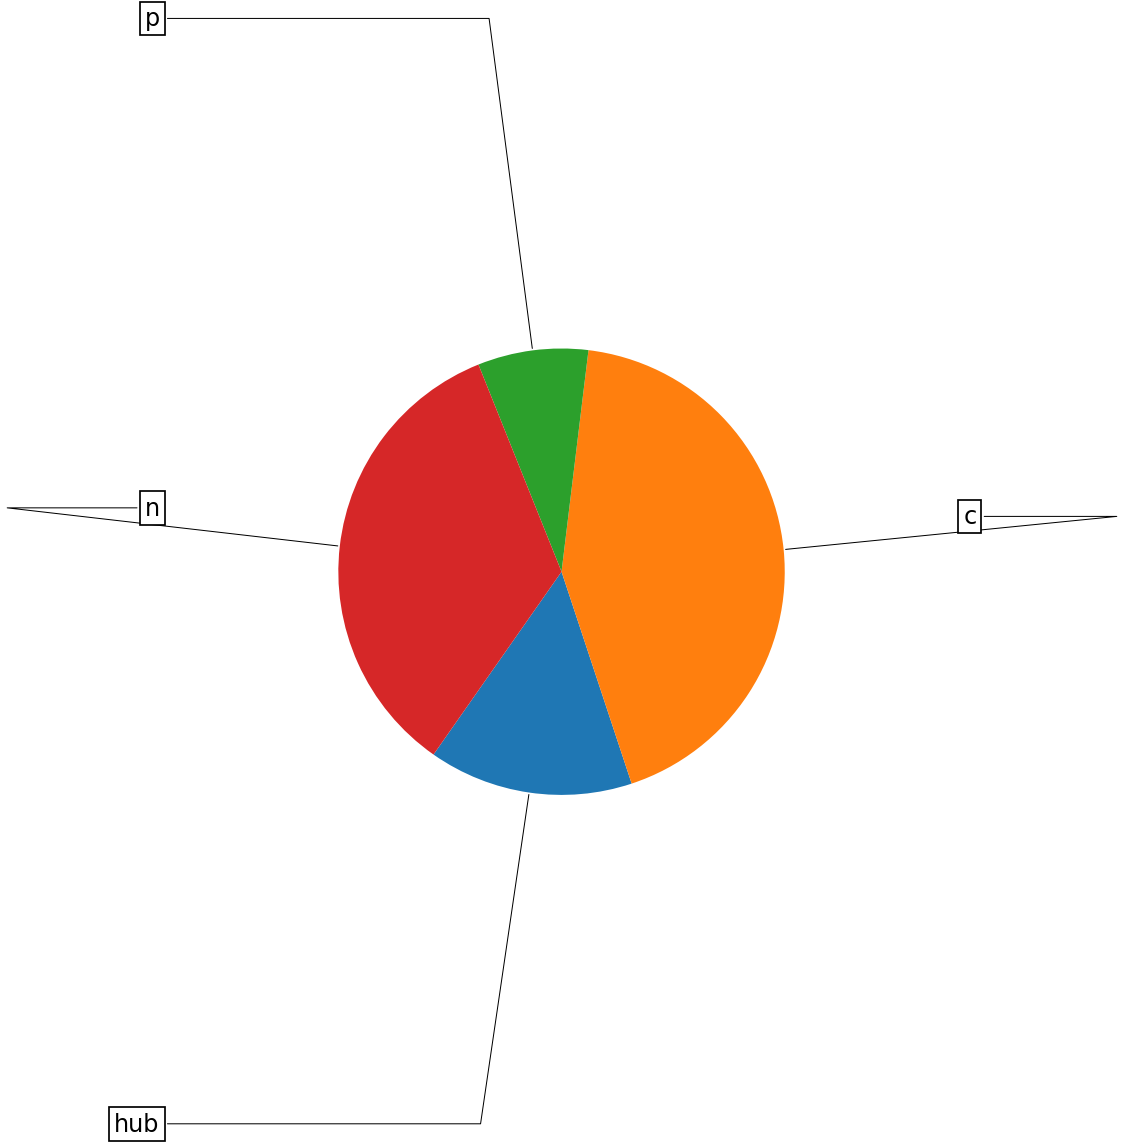

In [7]:
#Here, we show the proportion of the chemical classes in the entire CTD 
fig, ax = plt.subplots(figsize=(10, 20), subplot_kw=dict(aspect="equal"))
radius = 1

cmap = plt.cm.viridis



sizes=[len(hub_exposures_list),len(central_module_exposures_list),len(peripheric_module_exposures_list),len(no_central_no_module_exposures_list)]

wedges, texts = ax.pie(sizes, wedgeprops=dict(width=1), startangle=-125)

bbox_props = dict(boxstyle="square,pad=0.2", fc="w", ec="k", lw=1.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

#for i, p in enumerate(wedges):
#    ang = (p.theta2 - p.theta1)/2. + p.theta1
#    y = np.sin(np.deg2rad(ang))
#    x = np.cos(np.deg2rad(ang))
#    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
#    kw["arrowprops"].update({"connectionstyle": connectionstyle})
#    ax.annotate(labels[i], xy=(x, y), xytext=(1.8*np.sign(x), 2.5*y),
                horizontalalignment=horizontalalignment,fontsize=24, **kw)
#plt.savefig('output/Figures/Figure3D.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.show()

In [4]:

# ----------------------------
# Pie-chart data
# ----------------------------
pie_labels = ['Hub exposures', 'Central module exposures', 'Peripheric module exposures', 'No central/no module exposures']
pie_sizes = [len(hub_exposures_list),
             len(central_module_exposures_list),
             len(peripheric_module_exposures_list),
             len(no_central_no_module_exposures_list)]

# Create dataframe
df_pie = pd.DataFrame({
    "Chemical_class": pie_labels,
    "Count": pie_sizes,
    "Proportion": [s / sum(pie_sizes) for s in pie_sizes]
})

# ----------------------------
# Save to same Excel file, single sheet
# ----------------------------
out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    df_pie.to_excel(writer, sheet_name="Fig3F", index=False)

print("Pie-chart source data saved successfully.")

Pie-chart source data saved successfully.


In [5]:
#Here, we import the merged PPI
ppi = pd.read_csv("input/PPI/autocore_symbol_lcc.csv",delimiter= ',',
           skipinitialspace=True)
G_ppi = nx.from_pandas_edgelist(ppi, 'symbol1', 'symbol2')
G_ppi_lcc = G_ppi.subgraph(max(nx.connected_components(G_ppi), key=len))  # extract lcc graph
print(G_ppi_lcc.number_of_nodes())
print(G_ppi_lcc.number_of_edges())

18815
482935


In [50]:
#Let's build some dictionaries
chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])
        
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)           
    else:
        pass

chem_gene_dictio_cleaned_ppi={}
for k,v in chem_gene_cleaned.items():
    new_list=[]
    for gene in v:
        if gene in G_ppi_lcc.nodes():
            new_list.append(gene)
        else:
            pass
    if len(new_list)>0:
        chem_gene_dictio_cleaned_ppi[k]=new_list
    else:
        pass

#Let's build also the vice-versa: the gene-chem 
gene_chem = {}
for i,v in chem_homo.iterrows():
    try:
        gene_chem[v["GeneSymbol"]] |= {v["ChemicalID"]}
    except KeyError as e:
        gene_chem[v["GeneSymbol"]] = set([v["ChemicalID"]])
        
#Here the cleaning process
gene_chem_cleaned={}
for k,v in gene_chem.items():
    if len(v)!=0:
        gene_chem_cleaned[k]=v
    else:
        pass

In [51]:
#Let's import the median degree z-score
with open('output/exp_mediandegree_zscore.pickle', 'rb') as handle:
    exp_mediandegree_zscore = pk.load(handle)

with open('intermediate/final_exposome_zscore.pickle', 'rb') as handle:
    final_exposome_zscore = pk.load(handle)



In [33]:
exp_name = []
exp_type = []
exp_numgenes = []
exp_median_degree = []
exp_deg_zscore = []
exp_conn_zscore = []

for exp in hub_exposures_list:
    genelist = chem_gene_dictio_cleaned_ppi[exp]
    deg_list = [G_ppi_lcc.degree(gene) for gene in genelist]
    exp_name.append(exp)
    exp_type.append("Hub-exposure")
    exp_numgenes.append(len(genelist))
    exp_median_degree.append(np.median(deg_list))
    try:
        exp_deg_zscore.append(exp_mediandegree_zscore[exp])
    except:
        exp_deg_zscore.append("nan")
    try:
        exp_conn_zscore.append(final_exposome_zscore[exp])
    except:
        exp_conn_zscore.append("nan")
    
for exp in central_module_exposures_list:
    genelist = chem_gene_dictio_cleaned_ppi[exp]
    deg_list = [G_ppi_lcc.degree(gene) for gene in genelist]
    exp_name.append(exp)
    exp_type.append("Central-module exposure")
    exp_numgenes.append(len(genelist))
    exp_median_degree.append(np.median(deg_list))
    try:
        exp_deg_zscore.append(exp_mediandegree_zscore[exp])
    except:
        exp_deg_zscore.append("nan")
    try:
        exp_conn_zscore.append(final_exposome_zscore[exp])
    except:
        exp_conn_zscore.append("nan")

for exp in peripheric_module_exposures_list:
    genelist = chem_gene_dictio_cleaned_ppi[exp]
    deg_list = [G_ppi_lcc.degree(gene) for gene in genelist]
    exp_name.append(exp)
    exp_type.append("Peripheral-module exposure")
    exp_numgenes.append(len(genelist))
    exp_median_degree.append(np.median(deg_list))
    try:
        exp_deg_zscore.append(exp_mediandegree_zscore[exp])
    except:
        exp_deg_zscore.append("nan")
    try:
        exp_conn_zscore.append(final_exposome_zscore[exp])
    except:
        exp_conn_zscore.append("nan")

for exp in no_central_no_module_exposures_list:
    genelist = chem_gene_dictio_cleaned_ppi[exp]
    deg_list = [G_ppi_lcc.degree(gene) for gene in genelist]
    exp_name.append(exp)
    exp_type.append("Scattered exposure")
    exp_numgenes.append(len(genelist))
    exp_median_degree.append(np.median(deg_list))
    try:
        exp_deg_zscore.append(exp_mediandegree_zscore[exp])
    except:
        exp_deg_zscore.append("nan")
    try:
        exp_conn_zscore.append(final_exposome_zscore[exp])
    except:
        exp_conn_zscore.append("nan")


exp_ppi_df = pd.DataFrame()
exp_ppi_df["Exposure ID"] = exp_name
exp_ppi_df["Type"] = exp_type
exp_ppi_df["Number of Perturbed Genes in the PPI"] = exp_numgenes
exp_ppi_df["Median Degree in the PPI"] = exp_median_degree
exp_ppi_df["Median Degree z-score"] = exp_deg_zscore
exp_ppi_df["Connectivity z-score"] = exp_conn_zscore

exp_ppi_df.to_csv("output/exp_ppi_df.tsv",sep="\t")

In [8]:
#Let's define a dictionary that will convert the chemical ID in chemical name
chem_id_cas_conversion = {}
for i,v in chem_homo.iterrows():
        chem_id_cas_conversion[v["ChemicalID"]] = v["CasRN"]

In [9]:
#Let's define a dictionary that will convert the chemical ID in chemical name
chem_id_name_conversion = {}
for i,v in chem_gene_df.iterrows():
        chem_id_name_conversion[v["ChemicalID"]] = v["# ChemicalName"]

In [20]:

with open('output/CTDNameID.txt', 'w') as f:  # Open file in write mode
    for chemname, chemid in chem_id_name_conversion.items():  # Iterate over key-value pairs in your dictionary
        f.write(str(chemname) + '\t' + str(chemid) + '\n')  

In [10]:
chem_id_name_conversion_inv={}
for k,v in chem_id_name_conversion.items():
    chem_id_name_conversion_inv[v]=k

In [11]:
chem_id_cas_conversion_inv={}
for k,v in chem_id_cas_conversion.items():
    chem_id_cas_conversion_inv[v]=k

In [12]:
#We are importing the toxicity data (Hazard) from NORMANN (Susdata0), this was updated at 18.01.2022
#(https://www.norman-network.com/nds/SLE/)
#We will use the hazard value 'HazScore_EcoChronic_KEMI', which ranges from 0 (no toxic) to 1 (super harmful)
#this score was calculated based on the hazard in ecosystem and as chronic exposures and it was reported by
#KEMI Market list, a list of the 30418 chemical compounds that are available in the EU market
#https://comptox.epa.gov/dashboard/chemical-lists/KEMIMARKET


susdat_toxicity_df=pd.read_excel('input/NORMANN/susdat_2022-01-18-104316.xlsx', index_col=0)  

In [52]:
susdat_toxicity_ctd_full_dict = {}

susdat_toxicity_name_low_dict = {}
for i in susdat_toxicity_df['Name'].tolist():
    susdat_toxicity_name_low_dict[i.lower()] = i
    
susdat_toxicity_name_dash_low_dict = {}
for i in susdat_toxicity_df['Name_Dashboard'].tolist():
    susdat_toxicity_name_dash_low_dict[str(i).lower()] = i

susdat_toxicity_name_chem_low_list = {}
for i in susdat_toxicity_df['Name_ChemSpider'].tolist():
    susdat_toxicity_name_chem_low_list[str(i).lower()] = i

susdat_toxicity_name_iupac_low_list = {}
for i in susdat_toxicity_df['Name_IUPAC'].tolist():
    susdat_toxicity_name_iupac_low_list[str(i).lower()] = i

susdat_toxicity_name_chemsyn_low_list = {}
for i in susdat_toxicity_df['Synonyms_ChemSpider'].tolist():
    susdat_toxicity_name_chemsyn_low_list[str(i).lower()] = i

for chem_na,chem_id in chem_id_name_conversion_inv.items():
    chem_name = chem_na.lower()
    try:
        haz=susdat_toxicity_df[susdat_toxicity_df['Name']==susdat_toxicity_name_low_dict[chem_name]]['HazScore_EcoChronic_KEMI'].values[0]
        susdat_toxicity_ctd_full_dict[chem_id]=haz
    except:
        try:
            haz=susdat_toxicity_df[susdat_toxicity_df['Name_Dashboard']==susdat_toxicity_name_dash_low_dict[chem_name]]['HazScore_EcoChronic_KEMI'].values[0]
            susdat_toxicity_ctd_full_dict[chem_id]=haz
        except:
            try:
                haz=susdat_toxicity_df[susdat_toxicity_df['Name_ChemSpider']==susdat_toxicity_name_chem_low_list[chem_name]]['HazScore_EcoChronic_KEMI'].values[0]
                susdat_toxicity_ctd_full_dict[chem_id]=haz
            except:
                try:
                    haz=susdat_toxicity_df[susdat_toxicity_df['Name_IUPAC']==susdat_toxicity_name_iupac_low_list[chem_name]]['HazScore_EcoChronic_KEMI'].values[0]
                    susdat_toxicity_ctd_full_dict[chem_id]=haz
                except:
                    try:
                        haz=susdat_toxicity_df[susdat_toxicity_df['Synonyms_ChemSpider']==susdat_toxicity_name_chemsyn_low_list[chem_name]]['HazScore_EcoChronic_KEMI'].values[0]
                        susdat_toxicity_ctd_full_dict[chem_id]=haz
                    except:
                        pass

for chem_cas,chem_id in chem_id_cas_conversion_inv.items():
    if chem_id not in susdat_toxicity_ctd_full_dict.keys():    
        try:
            haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN']=="CAS_RN:"+chem_cas]['HazScore_EcoChronic_KEMI'].values[0]
            susdat_toxicity_ctd_full_dict[exp]=haz
        except:
            try:
                haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN_Dashboard']==chem_cas]['HazScore_EcoChronic_KEMI'].values[0]
                susdat_toxicity_ctd_full_dict[exp]=haz
            except: 
                pass


print(len(susdat_toxicity_ctd_full_dict))


4669


In [16]:
len(susdat_toxicity_ctd_full_dict)/len(chem_gene_dictio_cleaned_ppi)

0.47381242387332523

In [20]:
#Let's see whether there's any preferential chemical class that is missing from the hazard
with open('intermediate/d_classes.pickle', 'rb') as handle:
    d_classes = pk.load(handle)

#Here, we define the fisher test that we will use
def overlap_set(setA, setB,background):    
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    M= background #total number of exposures in chem_gene_cleaned
    n= len(setA)
    N= len(setB)
    x= len(setA.intersection(setB))
    return str(stats.hypergeom.sf(x-1, M, n, N))

#Here we define the adjustment
from statsmodels.sandbox.stats.multicomp import multipletests
def fdr_adjustment(list_of_pvals,alpha):    
    return multipletests(list_of_pvals,alpha=alpha,method='fdr_bh')[1] #the benjamin hochberg method is used

In [23]:

missing_chem = []
for chem in chem_gene_dictio_cleaned_ppi.keys():
    if chem not in susdat_toxicity_ctd_full_dict.keys():
        missing_chem.append(chem)

missing_chem_pval = {}
missing_chem_fdr = {}

for chem_class,chemlist in d_classes.items():
    pval = float(overlap_set(set(missing_chem),set(chemlist),len(chem_gene_dictio_cleaned_ppi)))
    missing_chem_pval[chem_class] = pval


adj_pval=fdr_adjustment(list(missing_chem_pval.values()),0.05)
pair_list=list(missing_chem_pval.keys())
for i in range(len(adj_pval)):
    missing_chem_fdr[pair_list[i]]=adj_pval[i]

In [27]:
missing_chem_fdr

{'D011083': 0.1823854693116027,
 'D006571': 0.9340272079494817,
 'D008055': 1.8264056031190082e-07,
 'D009930': 0.9999999999999923,
 'D045424': 1.1447064837752485e-16,
 'D007287': 0.6861673254222268,
 'D002241': 1.8264056031190082e-07,
 'D001685': 1.294065187223938e-10,
 'D000602': 3.3641787012528767e-16,
 'D020164': 3.3641787012528767e-16,
 'D045762': 0.169668210712233,
 'D009706': 0.0011436982284394603}

In [15]:
hub_exposures_haz_dict={}
for exp in hub_exposures_list:
    try:
        hub_exposures_haz_dict[exp] = susdat_toxicity_ctd_full_dict[exp]
    except:
        pass

peripheric_module_haz_dict={}
for exp in peripheric_module_exposures_list:
    try:
        peripheric_module_haz_dict[exp] = susdat_toxicity_ctd_full_dict[exp]
    except:
        pass

central_module_haz_dict={}
for exp in central_module_exposures_list:
    try:
        central_module_haz_dict[exp] = susdat_toxicity_ctd_full_dict[exp]
    except:
        pass

no_central_no_module_exposures_dict={}
for exp in no_central_no_module_exposures_list:
    try:
        no_central_no_module_exposures_dict[exp] = susdat_toxicity_ctd_full_dict[exp]
    except:
        pass

print("This is the ratio of found exposures with hazard annotation for hub exposures: %s" %(len(hub_exposures_haz_dict)/len(hub_exposures_list)))
print("This is the ratio of found exposures with hazard annotation for central module exposures: %s" %(len(central_module_haz_dict)/len(central_module_exposures_list)))
print("This is the ratio of found exposures with hazard annotation for peripheric module exposures: %s" %(len(peripheric_module_haz_dict)/len(peripheric_module_exposures_list)))
print("This is the ratio of found exposures with hazard annotation for no module no hub exposures: %s" %(len(no_central_no_module_exposures_dict)/len(no_central_no_module_exposures_list)))


This is the ratio of found exposures with hazard annotation for hub exposures: 0.35435229609321456
This is the ratio of found exposures with hazard annotation for central module exposures: 0.40920897284533647
This is the ratio of found exposures with hazard annotation for peripheric module exposures: 0.40609137055837563
This is the ratio of found exposures with hazard annotation for no module no hub exposures: 0.36112759643916914


In [16]:
import pandas as pd
column_names = ["Hazard", "Group"]

haz_count_df = pd.DataFrame(columns = column_names)

for val in list(hub_exposures_haz_dict.values()):
    if str(val)!='nan':
        new_row={"Hazard":val,"Group":"Hub"}
        haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)
    
for val in list(central_module_haz_dict.values()):
    if str(val)!='nan':
        new_row={"Hazard":val,"Group":"Central Module"}
        haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)
    
for val in list(peripheric_module_haz_dict.values()):
    if str(val)!='nan':
        new_row={"Hazard":val,"Group":"Peripheral Module"}
        haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)
    
    
for val in list(no_central_no_module_exposures_dict.values()):
    if str(val)!='nan':
        new_row={"Hazard":val,"Group":"Scattered"}
        haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_37255/2399414858.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)


/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_7320/1485264548.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(data=haz_count_df,x="Group", y="Hazard",order=["Central Module","Hub","Peripheral Module","Scattered"],palette=my_pal,linewidth=5)


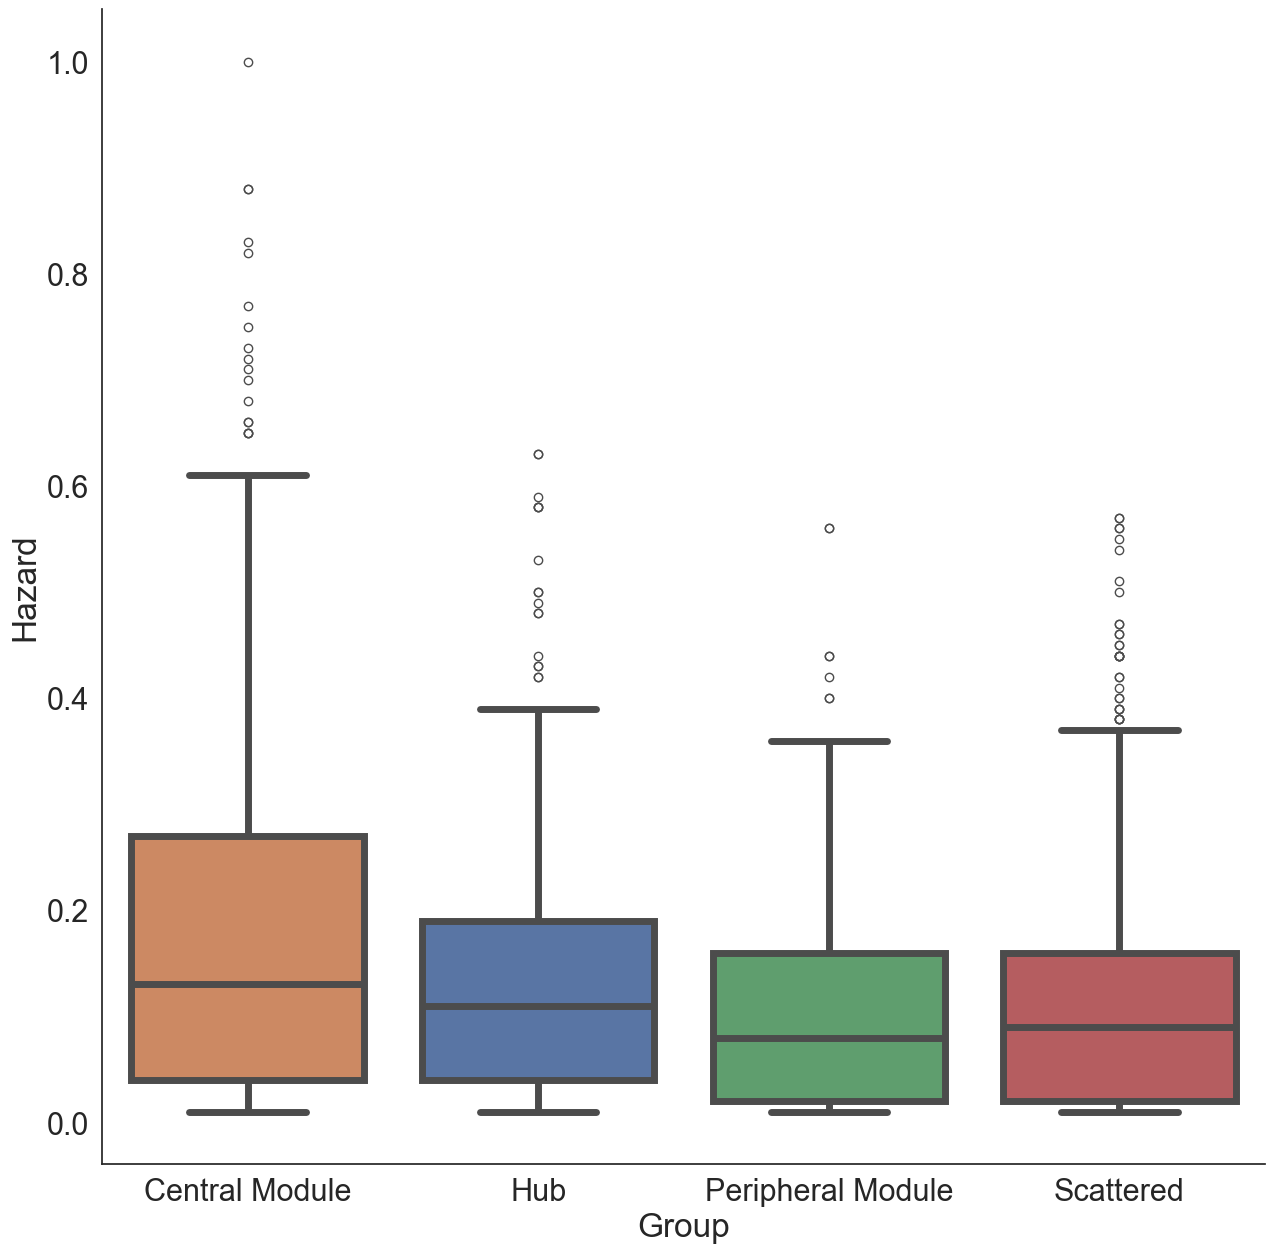

In [82]:
from itertools import combinations
pairs = list(combinations(list(set(haz_count_df['Group'])), r=2))


#Let's visualize as boxplot
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

list_palette=list(sns.color_palette())

my_pal = {"Central Module":list_palette[1] , "Hub": list_palette[0], "Peripheral Module":list_palette[2], "Scattered":list_palette[3]}


g=sns.boxplot(data=haz_count_df,x="Group", y="Hazard",order=["Central Module","Hub","Peripheral Module","Scattered"],palette=my_pal,linewidth=5)

ax.grid(False)

plt.savefig('output/Figures/Fig3G_v06.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.show()

In [18]:
palette = {"Central Module":"#DF5435" , "Hub": "#EDAB49", "Peripheral Module":"#E88F87", "Scattered":"#F9E5C8"}
haz_count_df["Color"] = haz_count_df["Group"].map(palette)

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    haz_count_df.to_excel(
        writer,
        sheet_name="Fig3G",
        index=False
    )


In [48]:
#Let's make some statistics
import scipy

hub_haz_list_cleaned = [i for i in list(hub_exposures_haz_dict.values()) if str(i)!='nan']
nocentral_nomodule_haz_list_cleaned = [i for i in list(no_central_no_module_exposures_dict.values()) if str(i)!='nan']
peripheric_module_haz_list_cleaned = [i for i in list(peripheric_module_haz_dict.values()) if str(i)!='nan']
central_module_haz_list_cleaned = [i for i in list(central_module_haz_dict.values()) if str(i)!='nan']



print(scipy.stats.mannwhitneyu(hub_haz_list_cleaned, nocentral_nomodule_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(central_module_haz_list_cleaned, nocentral_nomodule_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(peripheric_module_haz_list_cleaned, nocentral_nomodule_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(central_module_haz_list_cleaned, peripheric_module_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(hub_haz_list_cleaned, central_module_haz_list_cleaned, use_continuity=True, alternative='two-sided'))




MannwhitneyuResult(statistic=226838.5, pvalue=0.02428842344923827)
MannwhitneyuResult(statistic=866277.5, pvalue=6.185817331272729e-16)
MannwhitneyuResult(statistic=125361.5, pvalue=0.28454259895208334)
MannwhitneyuResult(statistic=245288.5, pvalue=1.7545824498236355e-09)
MannwhitneyuResult(statistic=282843.5, pvalue=0.00013957768411437826)


In [19]:
susdat_toxicity_df[susdat_toxicity_df['Name']=='Endrin ']['HazScore_EcoChronic_KEMI'].values[0]

0.31

In [45]:
for exp,haz in hub_exposures_haz_dict.items():
    if haz<=0.3:
        if len(chem_gene_dictio_cleaned_ppi[exp])<20:
            if len(set(chem_gene_dictio_cleaned_ppi['D004732'])&set(chem_gene_dictio_cleaned_ppi[exp]))<1:
                if len(set(chem_gene_dictio_cleaned_ppi['D014641'])&set(chem_gene_dictio_cleaned_ppi[exp]))<1:
                    G_ppi_sub = G_ppi.subgraph(chem_gene_dictio_cleaned_ppi[exp]) 
                    if G_ppi_sub.number_of_edges()>4:
                        for gene in chem_gene_dictio_cleaned_ppi[exp]:
                            if nx.degree(G_ppi,gene)>50:
                                print(exp,haz)


C027667 0.15
C027667 0.15
C027667 0.15
C036758 0.17
C036758 0.17
C036758 0.17
C055802 0.13
C055802 0.13
C030735 0.1
C030735 0.1
C030735 0.1
C030735 0.1
C030735 0.1
C030735 0.1
C030735 0.1
D000086 0.1
D000086 0.1
C031800 0.04
C031800 0.04
D019386 0.08
D019386 0.08
D019386 0.08
D019386 0.08
D019386 0.08
D000583 0.17
D000583 0.17
D000583 0.17
D000641 0.27
D000641 0.27
D000641 0.27
D000641 0.27
D000641 0.27
D000658 0.08
C018861 0.13
C018861 0.13
C019304 0.12
C019304 0.12
C019304 0.12
C019304 0.12
C019304 0.12
C007078 0.18
C007078 0.18
C007078 0.18
C007078 0.18
D004977 0.03
D004977 0.03
D005280 0.01
D005280 0.01
D005280 0.01
D005280 0.01
D000077604 0.04
D000077604 0.04
D000077604 0.04
D019807 0.04
D019807 0.04
D019807 0.04
D019807 0.04
D020366 0.27
D020105 0.1
D020105 0.1
D020105 0.1
D009583 0.04
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
D011441 0.16
D011441 0.16
D011441 0.16
D011441 0.16
D011441 0.16
D0

In [46]:
# open file in write mode
with open('output/Methylmethacrylate.txt', 'w') as fp:
    for item in chem_gene_dictio_cleaned_ppi['D020366']:
        # write each item on a new line
        fp.write("%s\n" % item)


In [34]:
# open file in write mode
with open('output/Benthiocarb.txt', 'w') as fp:
    for item in chem_gene_dictio_cleaned_ppi['C037925']:
        # write each item on a new line
        fp.write("%s\n" % item)


In [42]:
for exp,haz in peripheric_module_haz_dict.items():
    if haz<=0.2:
        if len(chem_gene_dictio_cleaned_ppi[exp])<20 and len(chem_gene_dictio_cleaned_ppi[exp])>3:
            if len(set(chem_gene_dictio_cleaned_ppi['D004732'])&set(chem_gene_dictio_cleaned_ppi[exp]))<1:
                G_ppi_sub = G_ppi.subgraph(chem_gene_dictio_cleaned_ppi[exp]) 
                if G_ppi_sub.number_of_edges()>10:
                    print(exp,haz)

D015104 0.04
C035253 0.01
D001640 0.1
C075375 0.01
D006923 0.02
D008717 0.01
D010852 0.02
D012603 0.01
D014641 0.01


In [43]:
# open file in write mode
with open('output/Vanillic_acid.txt', 'w') as fp:
    for item in chem_gene_dictio_cleaned_ppi['D014641']:
        # write each item on a new line
        fp.write("%s\n" % item)

In [33]:
# open file in write mode
with open('output/Diflubenzuron.txt', 'w') as fp:
    for item in chem_gene_dictio_cleaned_ppi['D004132']:
        # write each item on a new line
        fp.write("%s\n" % item)


In [49]:
np.max(central_module_haz_list_cleaned)

1.0

In [50]:
np.max(hub_haz_list_cleaned)

0.63

In [51]:
np.max(nocentral_nomodule_haz_list_cleaned)

0.57

In [52]:
np.max(peripheric_module_haz_list_cleaned)

0.56

In [53]:
np.median(central_module_haz_list_cleaned)

0.13

In [54]:
np.median(hub_haz_list_cleaned)

0.11

In [55]:
np.median(nocentral_nomodule_haz_list_cleaned)

0.09

In [56]:
np.median(peripheric_module_haz_list_cleaned)

0.08

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_7320/2142357301.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Group", y="Hazard", data=haz_count_df,


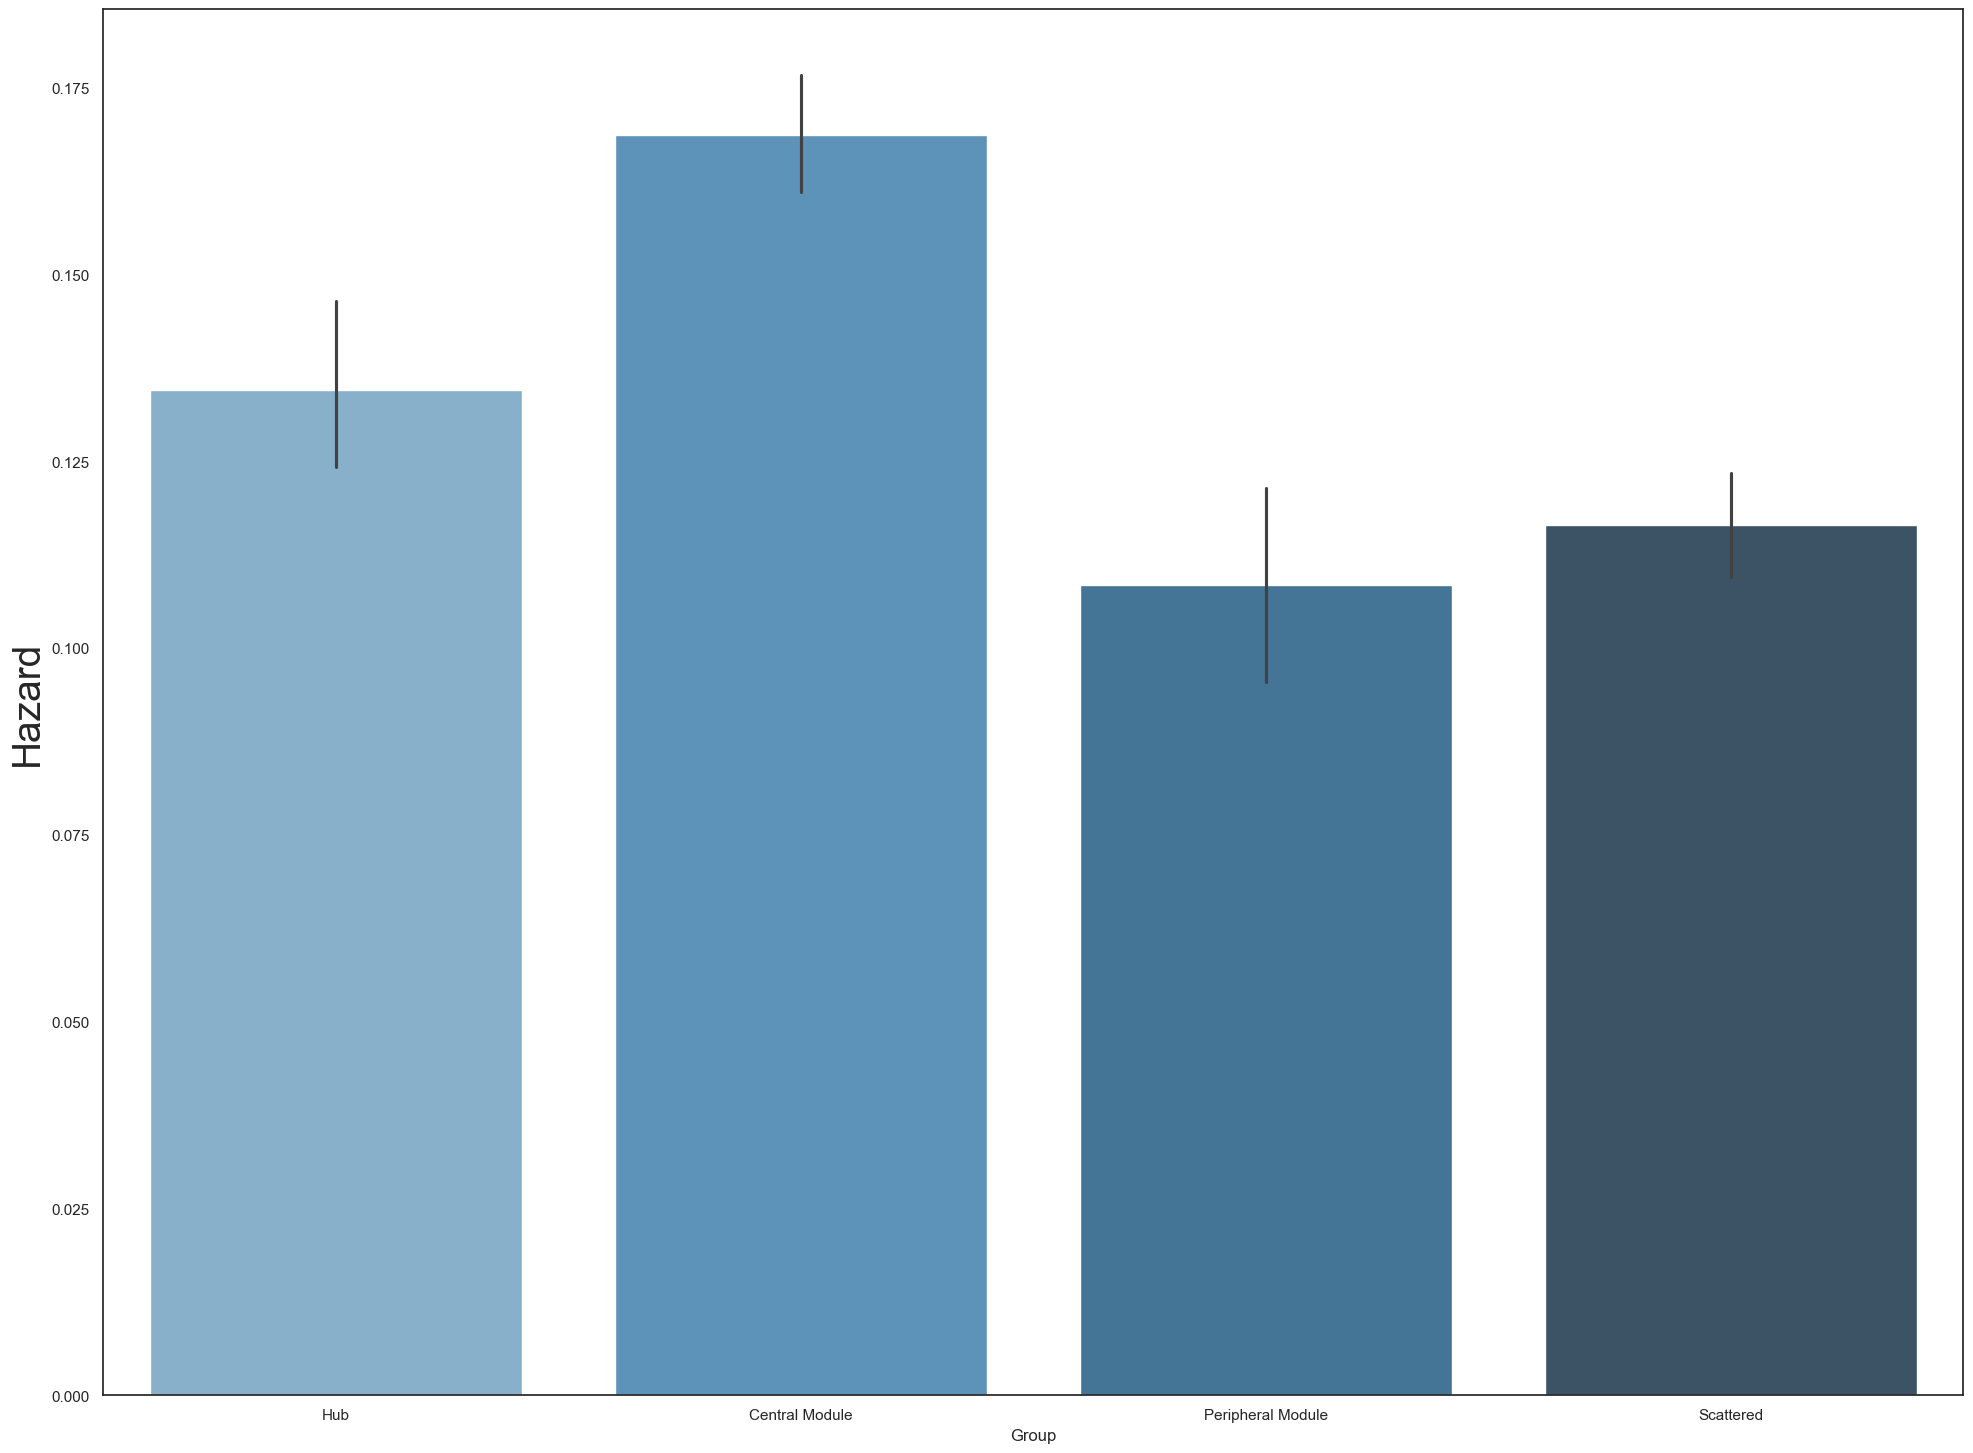

In [61]:
#Let's visualize as barplots
fig, ax = plt.subplots(figsize=(24, 18))
ax = sns.barplot(x="Group", y="Hazard", data=haz_count_df,
                 palette="Blues_d",estimator=np.mean)
#ax.set_yscale("log")
ax.set_ylabel("Hazard",fontsize=28)
#ax.set_xlabel("Group",fontsize=28)
plt.show()

In [53]:
#We do not observe any positive correlation between the median degree value and the Hazard, let's try considering
#the max degree

def max_degree(genelist):
    degree_list=[]
    for gene in genelist:
        degree_list.append(G_ppi_lcc.degree(gene))
    max_degree=max(degree_list)
    return max_degree

chem_max_degree={}
for chem, genelist in chem_gene_dictio_cleaned_ppi.items():
    chem_max_degree[chem]=max_degree(genelist)

In [54]:
#Then, we will make a correlation plot to visualize whether there is a positive correlation between degree and hazard
import scipy

max_deg_list=[]
haz_list=[]
for chem,haz in susdat_toxicity_ctd_full_dict.items():
    if str(haz)!='nan':
        try:
            max_deg_list.append(chem_max_degree[chem])
            haz_list.append(haz)
        except:
            pass


print(scipy.stats.pearsonr(max_deg_list,haz_list))  # Pearson's r
print(scipy.stats.spearmanr(max_deg_list,haz_list)) # Spearman's rho



PearsonRResult(statistic=0.23877955419391647, pvalue=2.739223192044562e-42)
SignificanceResult(statistic=0.18981391758174365, pvalue=4.5586056250674424e-27)


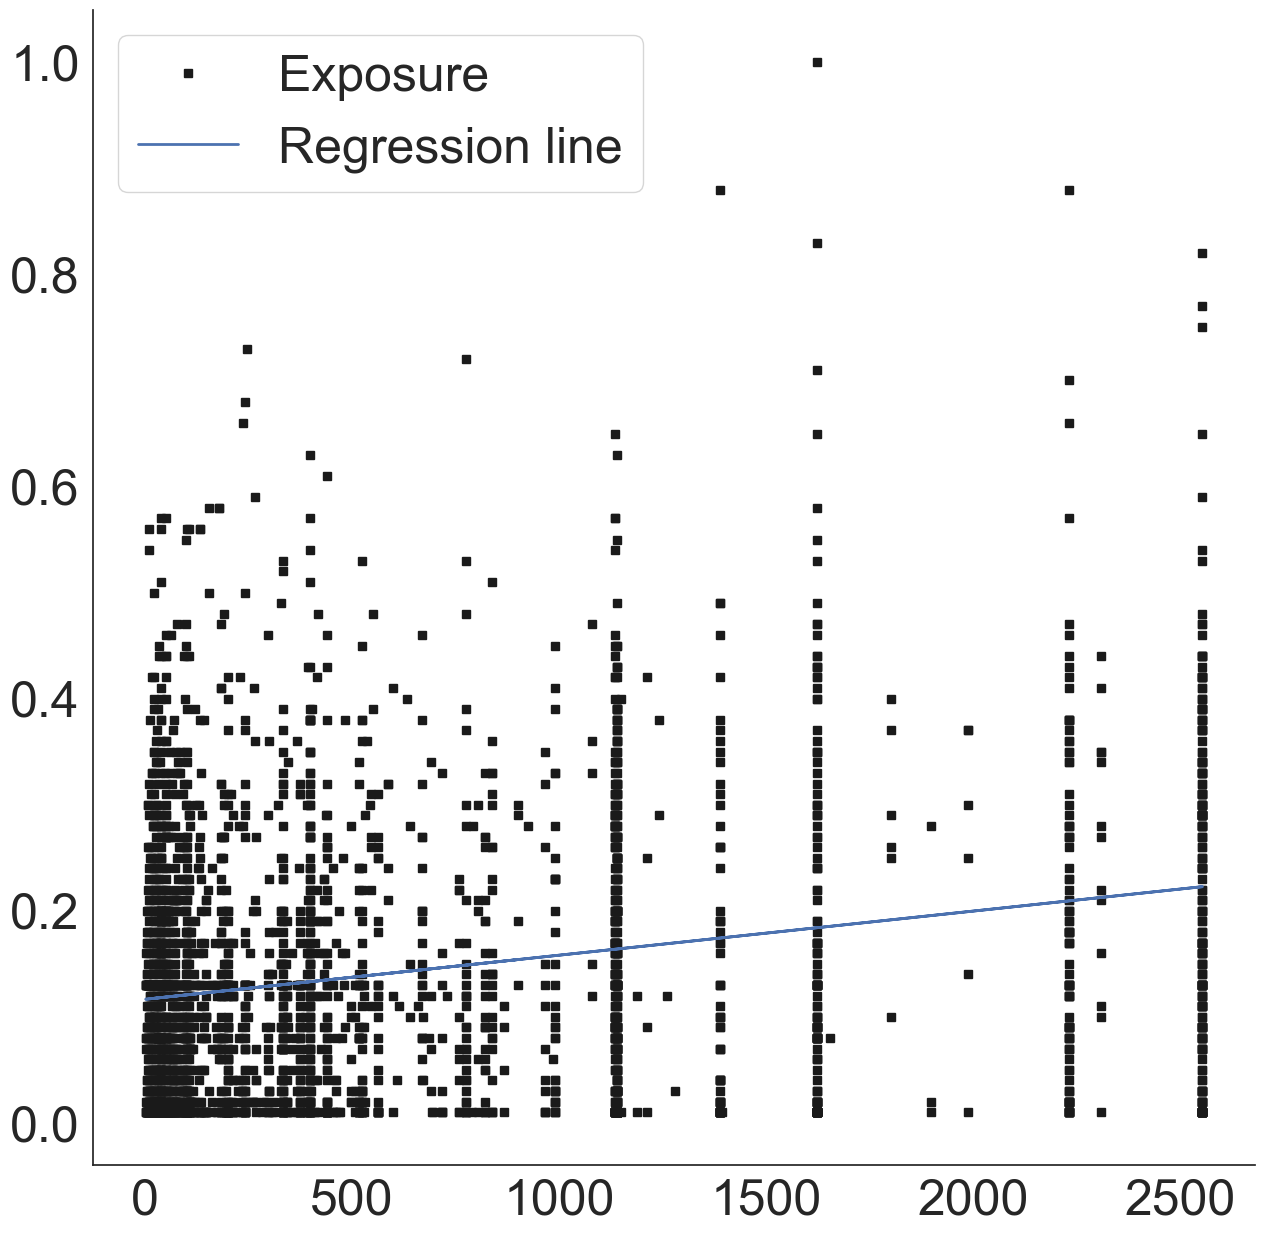

In [67]:

import scipy
from matplotlib.pyplot import figure
from scipy import stats


fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(max_deg_list, haz_list)

ax.plot(max_deg_list,haz_list, linewidth=0, marker='s',c='k', label='Exposure')
y=[]
for i in max_deg_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(max_deg_list, y, label=line,linewidth=2)
#ax.set_xlabel('Max degree value', fontsize=18)
#ax.set_ylabel('Hazard',fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

ax.legend(facecolor='white',fontsize=36)
#plt.savefig('output/Figures/Figure3Fv2.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [22]:
column_names = ["Hazard", "Degree"]

deg_haz_df = pd.DataFrame(columns = column_names)
deg_haz_df['Hazard']=haz_list
deg_haz_df['Degree']=max_deg_list

In [23]:
deg_haz_df_sort_by_degree=deg_haz_df.sort_values("Degree")

In [24]:
cat_list=[]
for i in range(len(deg_haz_df_sort_by_degree)):
    if i<len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("1st quintile")
    elif i>len(deg_haz_df_sort_by_degree)/5 and i<2*len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("2nd quintile")
    elif i>2*len(deg_haz_df_sort_by_degree)/5 and i<3*len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("3rd quintile")
    elif i>3*len(deg_haz_df_sort_by_degree)/5 and i<4*len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("4th quintile")
    else:
        cat_list.append("5th quintile")
        
deg_haz_df_sort_by_degree["Group"]=cat_list

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_7320/349719640.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([round(i,2) for i in ax.get_yticks()], size = 36)


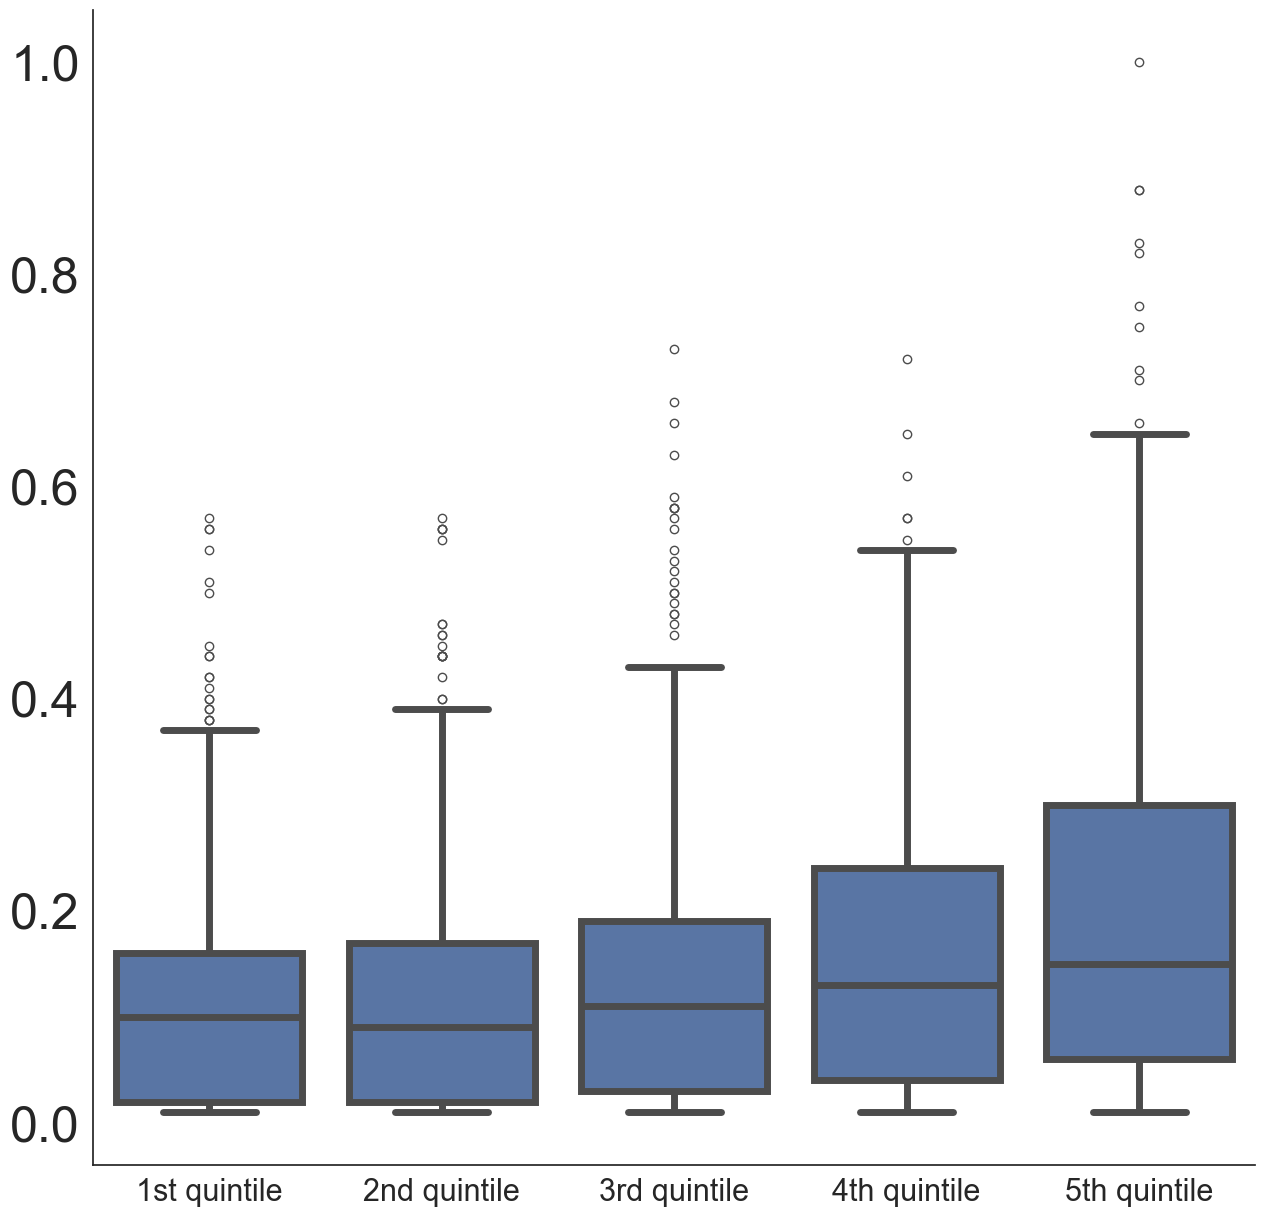

In [81]:
#Let's visualize as boxplot
import seaborn as sns
import matplotlib.pyplot as plt

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
fig, ax = plt.subplots(figsize=(15, 15))

sns.set_style('white')
sns.set(style="white",font_scale = 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
g=sns.boxplot(data=deg_haz_df_sort_by_degree,x="Group", y="Hazard",order=['1st quintile','2nd quintile', '3rd quintile','4th quintile',
 '5th quintile'],linewidth=5)
plt.xlabel('',fontsize=22)
plt.ylabel('', fontsize=22)
#plt.xticks([], fontsize=22)
ax.grid(False)
ax.set_yticklabels([round(i,2) for i in ax.get_yticks()], size = 36)
#ax.set_xticklabels(ax.get_xticks(), size = 36)
plt.savefig('output/Figures/Fig3H_v06.pdf',format='pdf',dpi=300, bbox_inches = "tight")
#g.set_yscale("log")

plt.show()


In [42]:


print(scipy.stats.mannwhitneyu(deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='1st quintile']['Hazard'].tolist(), deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='2nd quintile']['Hazard'].tolist(), use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='1st quintile']['Hazard'].tolist(), deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='3rd quintile']['Hazard'].tolist(), use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='1st quintile']['Hazard'].tolist(), deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='4th quintile']['Hazard'].tolist(), use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='1st quintile']['Hazard'].tolist(), deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='5th quintile']['Hazard'].tolist(), use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='2nd quintile']['Hazard'].tolist(), deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='3rd quintile']['Hazard'].tolist(), use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='2nd quintile']['Hazard'].tolist(), deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='4th quintile']['Hazard'].tolist(), use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='2nd quintile']['Hazard'].tolist(), deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='5th quintile']['Hazard'].tolist(), use_continuity=True, alternative='two-sided'))


print(scipy.stats.mannwhitneyu(deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='3rd quintile']['Hazard'].tolist(), deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='4th quintile']['Hazard'].tolist(), use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='3rd quintile']['Hazard'].tolist(), deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='5th quintile']['Hazard'].tolist(), use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='4th quintile']['Hazard'].tolist(), deg_haz_df_sort_by_degree[deg_haz_df_sort_by_degree['Group']=='5th quintile']['Hazard'].tolist(), use_continuity=True, alternative='two-sided'))




MannwhitneyuResult(statistic=200527.5, pvalue=0.9385109299874242)
MannwhitneyuResult(statistic=185296.0, pvalue=0.022861787890550538)
MannwhitneyuResult(statistic=166209.5, pvalue=1.7718630825290886e-07)
MannwhitneyuResult(statistic=147096.5, pvalue=8.316218729496692e-17)
MannwhitneyuResult(statistic=184493.0, pvalue=0.018647836471121417)
MannwhitneyuResult(statistic=166064.0, pvalue=1.9991616789068124e-07)
MannwhitneyuResult(statistic=147585.5, pvalue=2.233943678621656e-16)
MannwhitneyuResult(statistic=181184.5, pvalue=0.004218313651759442)
MannwhitneyuResult(statistic=161749.0, pvalue=1.6584198849731648e-09)
MannwhitneyuResult(statistic=178189.5, pvalue=0.00046375422377577697)


In [25]:

# Make a clean copy
df_box = deg_haz_df_sort_by_degree.copy()

# Ensure correct ordering
order = ['1st quintile',
         '2nd quintile',
         '3rd quintile',
         '4th quintile',
         '5th quintile']

df_box["Group"] = pd.Categorical(df_box["Group"],
                                 categories=order,
                                 ordered=True)

# Add numeric group index (useful for reviewers)
df_box["Group_index"] = df_box["Group"].cat.codes + 1

# Keep only relevant columns
df_box_export = df_box[["Group",
                        "Group_index",
                        "Hazard"]]

print("Total observations:", len(df_box_export))
print(df_box_export.groupby("Group").size())

# ----------------------------
# SAVE TO EXCEL
# ----------------------------

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_box_export.to_excel(writer,
                           sheet_name="Fig3H",
                           index=False)

print("Boxplot source data saved successfully.")

Total observations: 3165
Group
1st quintile    633
2nd quintile    632
3rd quintile    632
4th quintile    632
5th quintile    636
dtype: int64


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_37255/3546691187.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_box_export.groupby("Group").size())


Boxplot source data saved successfully.


In [83]:
exp_name = []
exp_type = []
max_deg_list=[]
haz_list=[]
for chem,haz in susdat_toxicity_ctd_full_dict.items():
    if str(haz)!='nan':
        try:
            max_deg_list.append(chem_max_degree[chem])
            haz_list.append(haz)
            exp_name.append(chem)
            if chem in hub_exposures_list:
                exp_type.append("Hub-exposure")
            elif chem in central_module_exposures_list:
                exp_type.append("Central-module exposure")
            elif chem in peripheric_module_exposures_list:
                exp_type.append("Peripheral-module exposure")
            else:
                 exp_type.append("Scattered exposure")
        except:
            pass

exp_haz_df = pd.DataFrame()
exp_haz_df["Exposure ID"] = exp_name
exp_haz_df["Type"] = exp_type
exp_haz_df["Max degree in the PPI"] = max_deg_list
exp_haz_df["Hazard"] = haz_list
exp_haz_df.to_csv("output/exp_haz_df.tsv",sep="\t")

In [63]:
#Let's test this correlation against a random sampling of the PPI for 1,000 times
import numpy as np
import random as rd
import scipy.stats

# Precompute
deg_dict = dict(G_ppi_lcc.degree())
nodes_list = list(G_ppi_lcc.nodes())
ppi_nodes_set = set(nodes_list)

rd_corr_list = []
S = 1000

for s in range(S):
    max_deg_list = []
    haz_list = []
    for chem, haz in susdat_toxicity_ctd_full_dict.items():
        if str(haz) != 'nan':
            try:
                chem_gene_cleaned_ppi_set = set(chem_gene_cleaned[chem]) & ppi_nodes_set
                gene_sample = rd.sample(nodes_list, len(chem_gene_cleaned_ppi_set))
                max_deg = max(deg_dict[g] for g in gene_sample)
                max_deg_list.append(max_deg)
                haz_list.append(haz)
            except:
                pass
    rd_corr_list.append(scipy.stats.spearmanr(max_deg_list, haz_list)[0])

# Real correlation
max_deg_list = []
haz_list = []
for chem, haz in susdat_toxicity_ctd_full_dict.items():
    if str(haz) != 'nan':
        try:
            chem_gene_cleaned_ppi_set = set(chem_gene_cleaned[chem]) & ppi_nodes_set
            max_deg = max(deg_dict[g] for g in chem_gene_cleaned_ppi_set)
            max_deg_list.append(max_deg)
            haz_list.append(haz)
        except:
            pass

real_deg_corr = scipy.stats.spearmanr(max_deg_list, haz_list)[0]

mu = np.mean(rd_corr_list)
std = np.std(rd_corr_list)

z = round((real_deg_corr - mu) / std, 3)

In [64]:
z

2.471

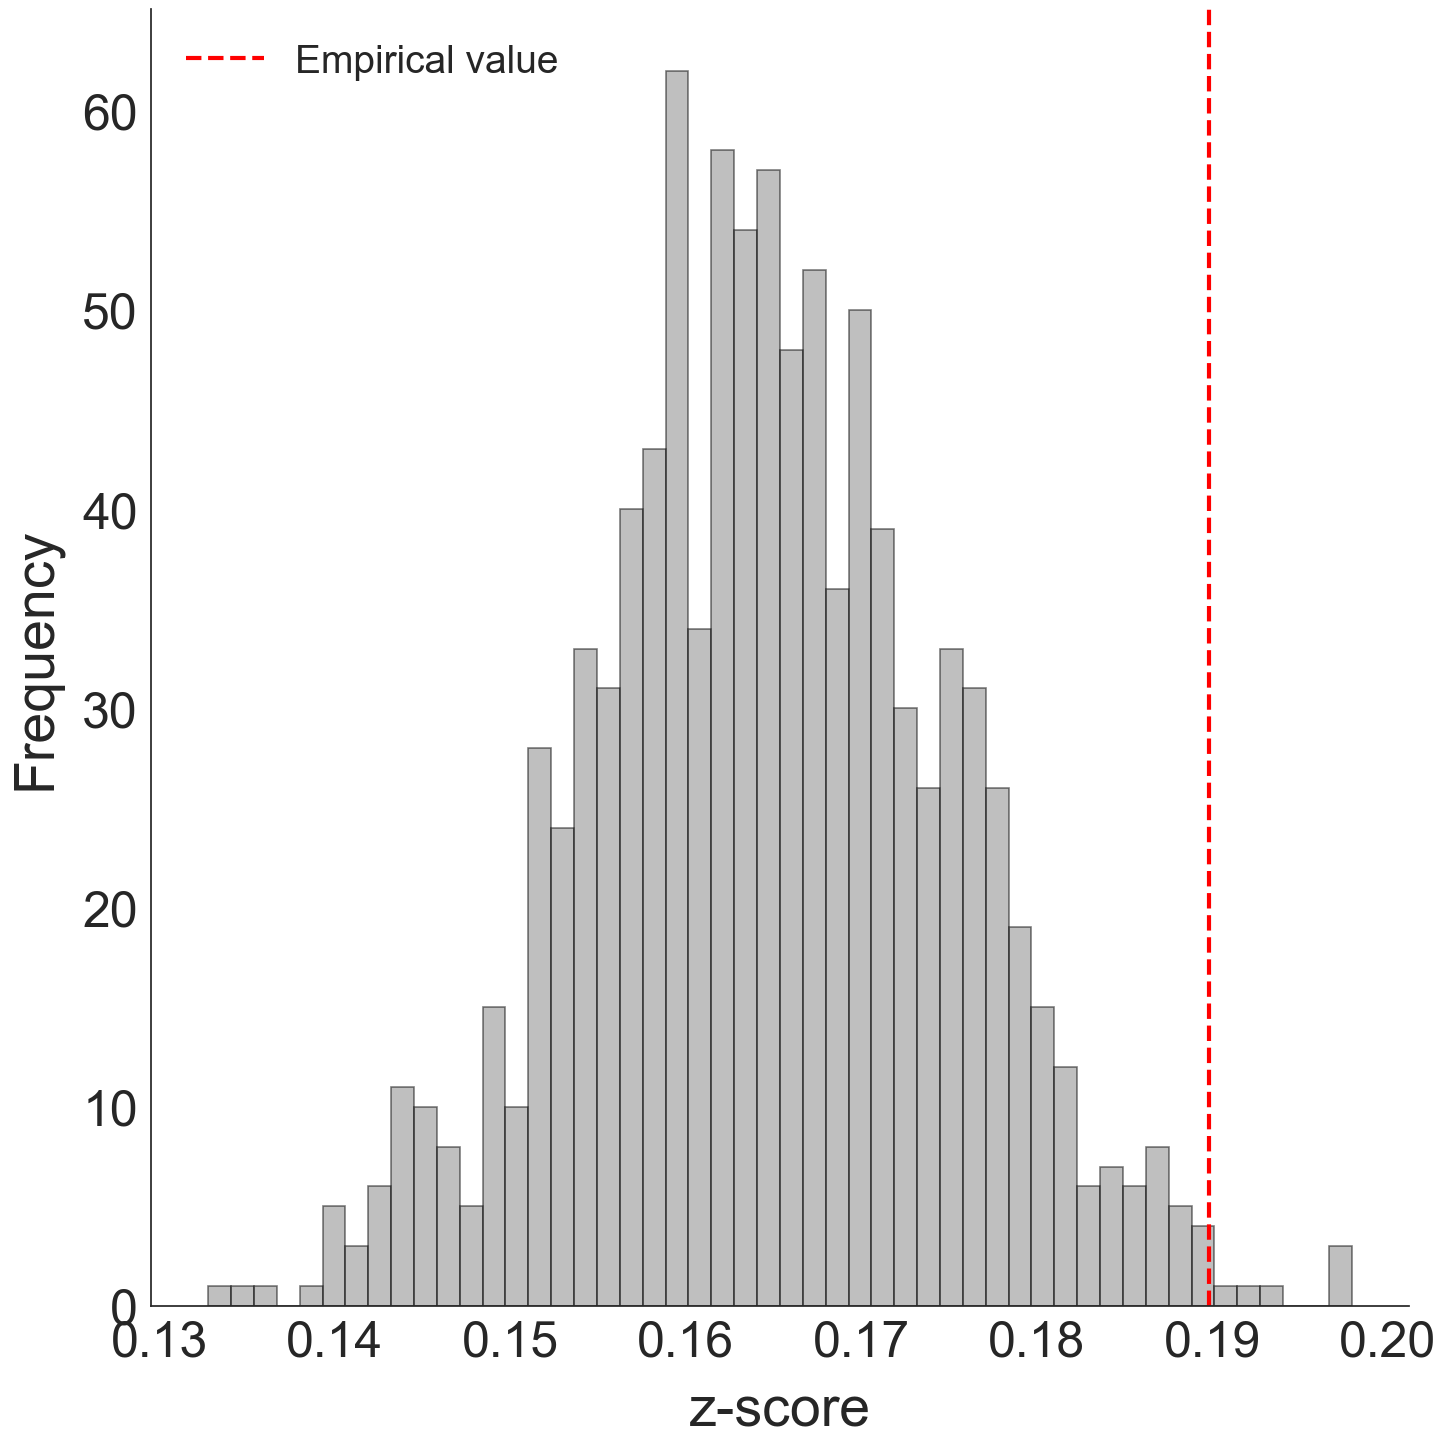

In [65]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))

# Histogram with nice borders
ax.hist(
    rd_corr_list,
    bins=50,
    color='grey',
    alpha=0.5,
    edgecolor='black',   # border color
    linewidth=1.2        # thicker border
)

# Clean up spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Style ticks
ax.tick_params(axis='x', labelsize=36)
ax.tick_params(axis='y', labelsize=36)

# Vertical line for empirical value
ax.axvline(
    x=real_deg_corr,
    ymin=0, ymax=1,
    color='red',
    linestyle='--',
    linewidth=3,
    label='Empirical value'
)

# Labels and title (optional)
ax.set_xlabel('z-score', fontsize=40, labelpad=15)
ax.set_ylabel('Frequency', fontsize=40, labelpad=15)

# Legend
ax.legend(fontsize=28, frameon=False)

plt.tight_layout()
plt.savefig("output/Figures/Corr_PPIHazard_zscore.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


In [66]:

# ----------------------------
# Raw values
# ----------------------------
z_array = np.array(rd_corr_list)

print("Total random simulations:", len(z_array))

# ----------------------------
# Compute histogram (50 bins)
# ----------------------------
counts, bin_edges = np.histogram(z_array, bins=50)

# Assign each value to a bin
bin_indices = np.digitize(z_array, bin_edges, right=False) - 1
bin_indices[bin_indices == 50] = 49  # fix rightmost edge case

# ----------------------------
# Build full dataframe
# ----------------------------
df_corr_hist = pd.DataFrame({
    "random_z_score": z_array,
    "bin_index": bin_indices,
    "bin_left": bin_edges[bin_indices],
    "bin_right": bin_edges[bin_indices + 1],
    "bin_count": counts[bin_indices],
    "log10_bin_count": np.where(counts[bin_indices] > 0,
                                np.log10(counts[bin_indices]),
                                np.nan),
    "empirical_value": real_deg_corr,
    "greater_equal_empirical": z_array >= real_deg_corr
})

print("Empirical value:", real_deg_corr)
print("Number ≥ empirical:", sum(z_array >= real_deg_corr))

# ----------------------------
# Save to Excel
# ----------------------------
out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_corr_hist.to_excel(writer,
                          sheet_name="SF14I",
                          index=False)

print("Correlation histogram source data saved successfully.")

Total random simulations: 1000
Empirical value: 0.18981391758174365
Number ≥ empirical: 6
Correlation histogram source data saved successfully.


In [26]:
#Let's look at the perturbed cases

with open('output/chem_gene_hq.pickle', 'rb') as handle:
    chem_gene_hq = pk.load(handle)
with open('output/chem_gene_homo_mouse.pickle', 'rb') as handle:
    chem_gene_homo_mouse = pk.load(handle)


In [28]:


#HOMO HQ

hub_exposures_list=[]
central_module_exposures_list=[]
peripheric_module_exposures_list=[]
no_central_no_module_exposures_list=[]
 
# Using readlines()
file1 = open('output/HomoHQ_Hub_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    hub_exposures_list.append(line.strip("\n"))

# Using readlines()
file1 = open('output/HomoHQ_Central_module_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    central_module_exposures_list.append(line.strip("\n"))
    
# Using readlines()
file1 = open('output/HomoHQ_Peripheric_module_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    peripheric_module_exposures_list.append(line.strip("\n"))
    
# Using readlines()
file1 = open('output/HomoHQ_No_central_no_module_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    no_central_no_module_exposures_list.append(line.strip("\n"))


hub_exposures_haz_dict={}
for exp in hub_exposures_list:
    try:
        hub_exposures_haz_dict[exp] = susdat_toxicity_ctd_full_dict[exp]
    except:
        pass

peripheric_module_haz_dict={}
for exp in peripheric_module_exposures_list:
    try:
        peripheric_module_haz_dict[exp] = susdat_toxicity_ctd_full_dict[exp]
    except:
        pass

central_module_haz_dict={}
for exp in central_module_exposures_list:
    try:
        central_module_haz_dict[exp] = susdat_toxicity_ctd_full_dict[exp]
    except:
        pass

no_central_no_module_exposures_dict={}
for exp in no_central_no_module_exposures_list:
    try:
        no_central_no_module_exposures_dict[exp] = susdat_toxicity_ctd_full_dict[exp]
    except:
        pass

print("This is the ratio of found exposures with hazard annotation for hub exposures: %s" %(len(hub_exposures_haz_dict)/len(hub_exposures_list)))
print("This is the ratio of found exposures with hazard annotation for central module exposures: %s" %(len(central_module_haz_dict)/len(central_module_exposures_list)))
print("This is the ratio of found exposures with hazard annotation for peripheric module exposures: %s" %(len(peripheric_module_haz_dict)/len(peripheric_module_exposures_list)))
print("This is the ratio of found exposures with hazard annotation for no module no hub exposures: %s" %(len(no_central_no_module_exposures_dict)/len(no_central_no_module_exposures_list)))


This is the ratio of found exposures with hazard annotation for hub exposures: 0.5729166666666666
This is the ratio of found exposures with hazard annotation for central module exposures: 0.5454545454545454
This is the ratio of found exposures with hazard annotation for peripheric module exposures: 0.5642458100558659
This is the ratio of found exposures with hazard annotation for no module no hub exposures: 0.4771101573676681


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_37255/2797137726.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_37255/2797137726.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(data=haz_count_df,x="Group", y="Hazard",order=["Central Module","Hub","Peripheral Module","Scattered"],palette=my_pal,linewidth=5)


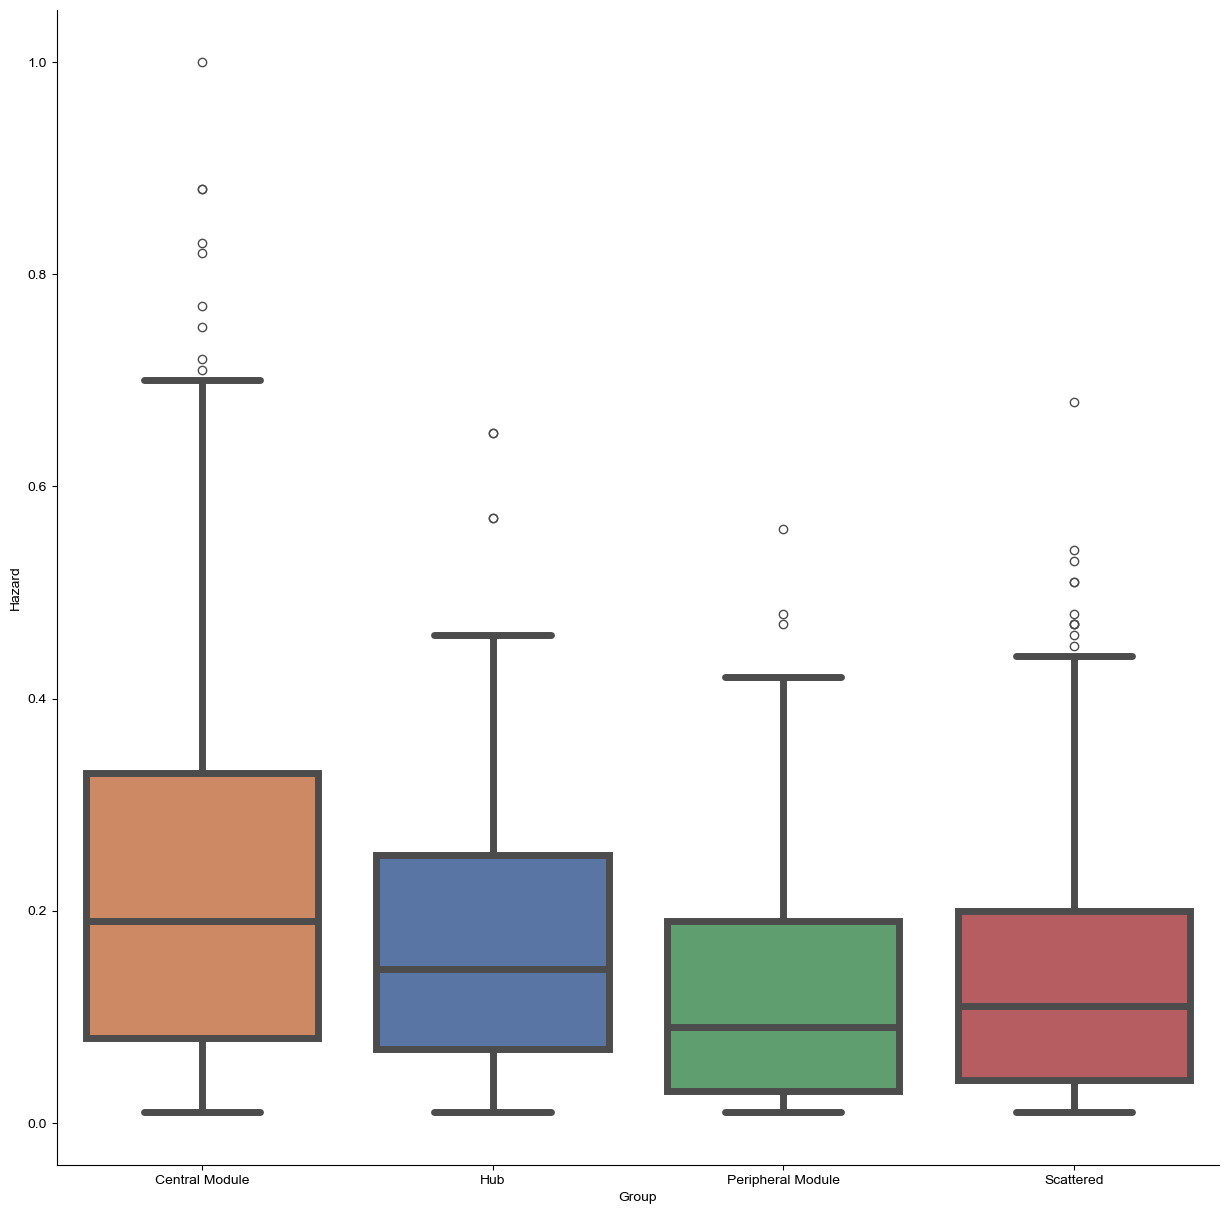

In [29]:
import pandas as pd
column_names = ["Hazard", "Group"]

haz_count_df = pd.DataFrame(columns = column_names)

for val in list(hub_exposures_haz_dict.values()):
    if str(val)!='nan':
        new_row={"Hazard":val,"Group":"Hub"}
        haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)
    
for val in list(central_module_haz_dict.values()):
    if str(val)!='nan':
        new_row={"Hazard":val,"Group":"Central Module"}
        haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)
    
for val in list(peripheric_module_haz_dict.values()):
    if str(val)!='nan':
        new_row={"Hazard":val,"Group":"Peripheral Module"}
        haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)
    
    
for val in list(no_central_no_module_exposures_dict.values()):
    if str(val)!='nan':
        new_row={"Hazard":val,"Group":"Scattered"}
        haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)
        
        from itertools import combinations
pairs = list(combinations(list(set(haz_count_df['Group'])), r=2))


#Let's visualize as boxplot
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

list_palette=list(sns.color_palette())

my_pal = {"Central Module":list_palette[1] , "Hub": list_palette[0], "Peripheral Module":list_palette[2], "Scattered":list_palette[3]}


g=sns.boxplot(data=haz_count_df,x="Group", y="Hazard",order=["Central Module","Hub","Peripheral Module","Scattered"],palette=my_pal,linewidth=5)

ax.grid(False)

#plt.savefig('output/Figures/SF7D_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.show()

In [33]:
palette = {"Central Module":"#DF5435" , "Hub": "#EDAB49", "Peripheral Module":"#E88F87", "Scattered":"#F9E5C8"}
haz_count_df["Color"] = haz_count_df["Group"].map(palette)

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    haz_count_df.to_excel(
        writer,
        sheet_name="SF14E",
        index=False
    )


In [20]:
#Let's make some statistics
import scipy

hub_haz_list_cleaned = [i for i in list(hub_exposures_haz_dict.values()) if str(i)!='nan']
nocentral_nomodule_haz_list_cleaned = [i for i in list(no_central_no_module_exposures_dict.values()) if str(i)!='nan']
peripheric_module_haz_list_cleaned = [i for i in list(peripheric_module_haz_dict.values()) if str(i)!='nan']
central_module_haz_list_cleaned = [i for i in list(central_module_haz_dict.values()) if str(i)!='nan']



print(scipy.stats.mannwhitneyu(hub_haz_list_cleaned, nocentral_nomodule_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(central_module_haz_list_cleaned, nocentral_nomodule_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(peripheric_module_haz_list_cleaned, nocentral_nomodule_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(central_module_haz_list_cleaned, peripheric_module_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(hub_haz_list_cleaned, central_module_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(hub_haz_list_cleaned, peripheric_module_haz_list_cleaned, use_continuity=True, alternative='two-sided'))



MannwhitneyuResult(statistic=47384.0, pvalue=0.00250335288602101)
MannwhitneyuResult(statistic=180891.5, pvalue=3.863892199791657e-13)
MannwhitneyuResult(statistic=23665.5, pvalue=0.3582765471189281)
MannwhitneyuResult(statistic=29416.0, pvalue=6.647327355500882e-06)
MannwhitneyuResult(statistic=32547.5, pvalue=0.040038118316432426)
MannwhitneyuResult(statistic=7789.5, pvalue=0.005669725286363029)


In [34]:
#We do not observe any positive correlation between the median degree value and the Hazard, let's try considering
#the max degree

def max_degree(genelist):
    degree_list=[]
    for gene in genelist:
        degree_list.append(G_ppi_lcc.degree(gene))
    max_degree=max(degree_list)
    return max_degree

chem_gene_hq_max_degree={}
for chem, genelist in chem_gene_hq.items():
    n_genelist = set(genelist) & G_ppi_lcc.nodes()
    if len(n_genelist)>0:
        chem_gene_hq_max_degree[chem]=max_degree(n_genelist)

In [35]:
#Then, we will make a correlation plot to visualize whether there is a positive correlation between degree and hazard
import scipy

max_deg_list=[]
haz_list=[]
for chem,haz in susdat_toxicity_ctd_full_dict.items():
    if str(haz)!='nan':
        try:
            max_deg_list.append(chem_gene_hq_max_degree[chem])
            haz_list.append(haz)
        except:
            pass


print(scipy.stats.pearsonr(max_deg_list,haz_list))  # Pearson's r
print(scipy.stats.spearmanr(max_deg_list,haz_list)) # Spearman's rho

PearsonRResult(statistic=0.23906366747534058, pvalue=1.864858100443993e-18)
SignificanceResult(statistic=0.2255285929992126, pvalue=1.5150424318012994e-16)


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_37255/3645915739.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([round(i,2) for i in ax.get_yticks()], size = 36)


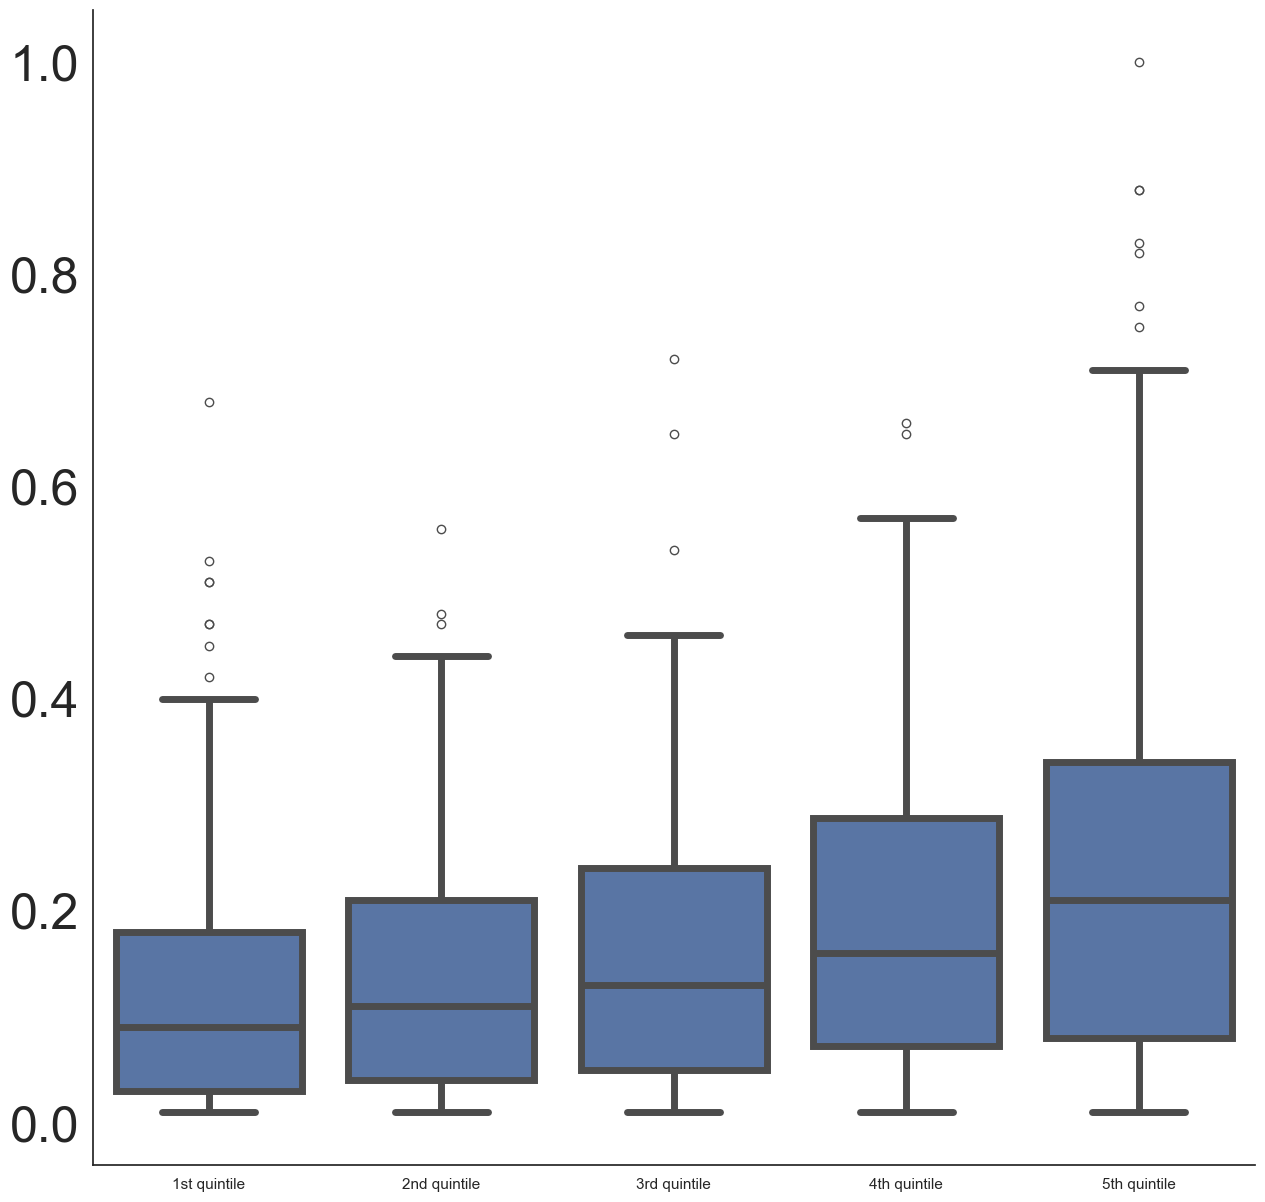

In [36]:
column_names = ["Hazard", "Degree"]

deg_haz_df = pd.DataFrame(columns = column_names)
deg_haz_df['Hazard']=haz_list
deg_haz_df['Degree']=max_deg_list
deg_haz_df_sort_by_degree=deg_haz_df.sort_values("Degree")
cat_list=[]
for i in range(len(deg_haz_df_sort_by_degree)):
    if i<len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("1st quintile")
    elif i>len(deg_haz_df_sort_by_degree)/5 and i<2*len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("2nd quintile")
    elif i>2*len(deg_haz_df_sort_by_degree)/5 and i<3*len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("3rd quintile")
    elif i>3*len(deg_haz_df_sort_by_degree)/5 and i<4*len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("4th quintile")
    else:
        cat_list.append("5th quintile")
        
deg_haz_df_sort_by_degree["Group"]=cat_list

#Let's visualize as boxplot
import seaborn as sns
import matplotlib.pyplot as plt

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
fig, ax = plt.subplots(figsize=(15, 15))

sns.set_style('white')
sns.set(style="white",font_scale = 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
g=sns.boxplot(data=deg_haz_df_sort_by_degree,x="Group", y="Hazard",order=['1st quintile','2nd quintile', '3rd quintile','4th quintile',
 '5th quintile'],linewidth=5)
plt.xlabel('',fontsize=22)
plt.ylabel('', fontsize=22)
#plt.xticks([], fontsize=22)
ax.grid(False)
ax.set_yticklabels([round(i,2) for i in ax.get_yticks()], size = 36)
#ax.set_xticklabels(ax.get_xticks(), size = 36)
#plt.savefig('output/Figures/SF7F_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
#g.set_yscale("log")

plt.show()

In [37]:

# Make a clean copy
df_box = deg_haz_df_sort_by_degree.copy()

# Ensure correct ordering
order = ['1st quintile',
         '2nd quintile',
         '3rd quintile',
         '4th quintile',
         '5th quintile']

df_box["Group"] = pd.Categorical(df_box["Group"],
                                 categories=order,
                                 ordered=True)

# Add numeric group index (useful for reviewers)
df_box["Group_index"] = df_box["Group"].cat.codes + 1

# Keep only relevant columns
df_box_export = df_box[["Group",
                        "Group_index",
                        "Hazard"]]

print("Total observations:", len(df_box_export))
print(df_box_export.groupby("Group").size())

# ----------------------------
# SAVE TO EXCEL
# ----------------------------

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_box_export.to_excel(writer,
                           sheet_name="SF14G",
                           index=False)

print("Boxplot source data saved successfully.")

Total observations: 1308
Group
1st quintile    262
2nd quintile    262
3rd quintile    261
4th quintile    262
5th quintile    261
dtype: int64


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_37255/4040018903.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_box_export.groupby("Group").size())


Boxplot source data saved successfully.


In [38]:
#HOMO MOUSE

chem_homo_mouse = chem_gene_df[chem_gene_df['Organism'].isin(['Homo sapiens', 'Mus musculus'])]

#Let's define a dictionary that will convert the chemical ID in chemical name
chem_id_cas_conversion_mouse = {}
for i,v in chem_homo_mouse.iterrows():
        chem_id_cas_conversion_mouse[v["ChemicalID"]] = v["CasRN"]

#Let's define a dictionary that will convert the chemical ID in chemical name
chem_id_name_conversion_mouse = {}
for i,v in chem_homo_mouse.iterrows():
        chem_id_name_conversion_mouse[v["ChemicalID"]] = v["# ChemicalName"]

chem_id_name_conversion_inv_mouse={}
for k,v in chem_id_name_conversion_mouse.items():
    chem_id_name_conversion_inv_mouse[v]=k

chem_id_cas_conversion_inv_mouse={}
for k,v in chem_id_cas_conversion_mouse.items():
    chem_id_cas_conversion_inv_mouse[v]=k

In [39]:
add_chem_mouse_list = []

for chem in chem_gene_homo_mouse.keys():
    if chem not in chem_gene_cleaned.keys():
        add_chem_mouse_list.append(chem)

print(len(add_chem_mouse_list))

1529


In [40]:
#Let's add some exposures coming from mouse

for chem_id in add_chem_mouse_list:
    chem_name = chem_id_name_conversion_mouse[chem_id].lower()
    try:
        haz=susdat_toxicity_df[susdat_toxicity_df['Name']==susdat_toxicity_name_low_dict[chem_name]]['HazScore_EcoChronic_KEMI'].values[0]
        susdat_toxicity_ctd_full_dict[chem_id]=haz
    except:
        try:
            haz=susdat_toxicity_df[susdat_toxicity_df['Name_Dashboard']==susdat_toxicity_name_dash_low_dict[chem_name]]['HazScore_EcoChronic_KEMI'].values[0]
            susdat_toxicity_ctd_full_dict[chem_id]=haz
        except:
            try:
                haz=susdat_toxicity_df[susdat_toxicity_df['Name_ChemSpider']==susdat_toxicity_name_chem_low_list[chem_name]]['HazScore_EcoChronic_KEMI'].values[0]
                susdat_toxicity_ctd_full_dict[chem_id]=haz
            except:
                try:
                    haz=susdat_toxicity_df[susdat_toxicity_df['Name_IUPAC']==susdat_toxicity_name_iupac_low_list[chem_name]]['HazScore_EcoChronic_KEMI'].values[0]
                    susdat_toxicity_ctd_full_dict[chem_id]=haz
                except:
                    try:
                        haz=susdat_toxicity_df[susdat_toxicity_df['Synonyms_ChemSpider']==susdat_toxicity_name_chemsyn_low_list[chem_name]]['HazScore_EcoChronic_KEMI'].values[0]
                        susdat_toxicity_ctd_full_dict[chem_id]=haz
                    except:
                        pass

for chem_id in add_chem_mouse_list:
    chem_cas = chem_id_cas_conversion_mouse[chem_id]
    if chem_id not in susdat_toxicity_ctd_full_dict.keys():    
        try:
            haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN']=="CAS_RN:"+chem_cas]['HazScore_EcoChronic_KEMI'].values[0]
            susdat_toxicity_ctd_full_dict[exp]=haz
        except:
            try:
                haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN_Dashboard']==chem_cas]['HazScore_EcoChronic_KEMI'].values[0]
                susdat_toxicity_ctd_full_dict[exp]=haz
            except: 
                pass


print(len(susdat_toxicity_ctd_full_dict))


4668


In [41]:


#HOMO Mouse

hub_exposures_list=[]
central_module_exposures_list=[]
peripheric_module_exposures_list=[]
no_central_no_module_exposures_list=[]
 
# Using readlines()
file1 = open('output/HomoMouse_Hub_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    hub_exposures_list.append(line.strip("\n"))

# Using readlines()
file1 = open('output/HomoMouse_Central_module_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    central_module_exposures_list.append(line.strip("\n"))
    
# Using readlines()
file1 = open('output/HomoMouse_Peripheric_module_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    peripheric_module_exposures_list.append(line.strip("\n"))
    
# Using readlines()
file1 = open('output/HomoMouse_No_central_no_module_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    no_central_no_module_exposures_list.append(line.strip("\n"))


hub_exposures_haz_dict={}
for exp in hub_exposures_list:
    try:
        hub_exposures_haz_dict[exp] = susdat_toxicity_ctd_full_dict[exp]
    except:
        pass

peripheric_module_haz_dict={}
for exp in peripheric_module_exposures_list:
    try:
        peripheric_module_haz_dict[exp] = susdat_toxicity_ctd_full_dict[exp]
    except:
        pass

central_module_haz_dict={}
for exp in central_module_exposures_list:
    try:
        central_module_haz_dict[exp] = susdat_toxicity_ctd_full_dict[exp]
    except:
        pass

no_central_no_module_exposures_dict={}
for exp in no_central_no_module_exposures_list:
    try:
        no_central_no_module_exposures_dict[exp] = susdat_toxicity_ctd_full_dict[exp]
    except:
        pass

print("This is the ratio of found exposures with hazard annotation for hub exposures: %s" %(len(hub_exposures_haz_dict)/len(hub_exposures_list)))
print("This is the ratio of found exposures with hazard annotation for central module exposures: %s" %(len(central_module_haz_dict)/len(central_module_exposures_list)))
print("This is the ratio of found exposures with hazard annotation for peripheric module exposures: %s" %(len(peripheric_module_haz_dict)/len(peripheric_module_exposures_list)))
print("This is the ratio of found exposures with hazard annotation for no module no hub exposures: %s" %(len(no_central_no_module_exposures_dict)/len(no_central_no_module_exposures_list)))


This is the ratio of found exposures with hazard annotation for hub exposures: 0.359792924935289
This is the ratio of found exposures with hazard annotation for central module exposures: 0.3920644274209389
This is the ratio of found exposures with hazard annotation for peripheric module exposures: 0.3625450180072029
This is the ratio of found exposures with hazard annotation for no module no hub exposures: 0.3244005641748942


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_37255/2470666535.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_37255/2470666535.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(data=haz_count_df,x="Group", y="Hazard",order=["Central Module","Hub","Peripheral Module","Scattered"],palette=my_pal,linewidth=5)


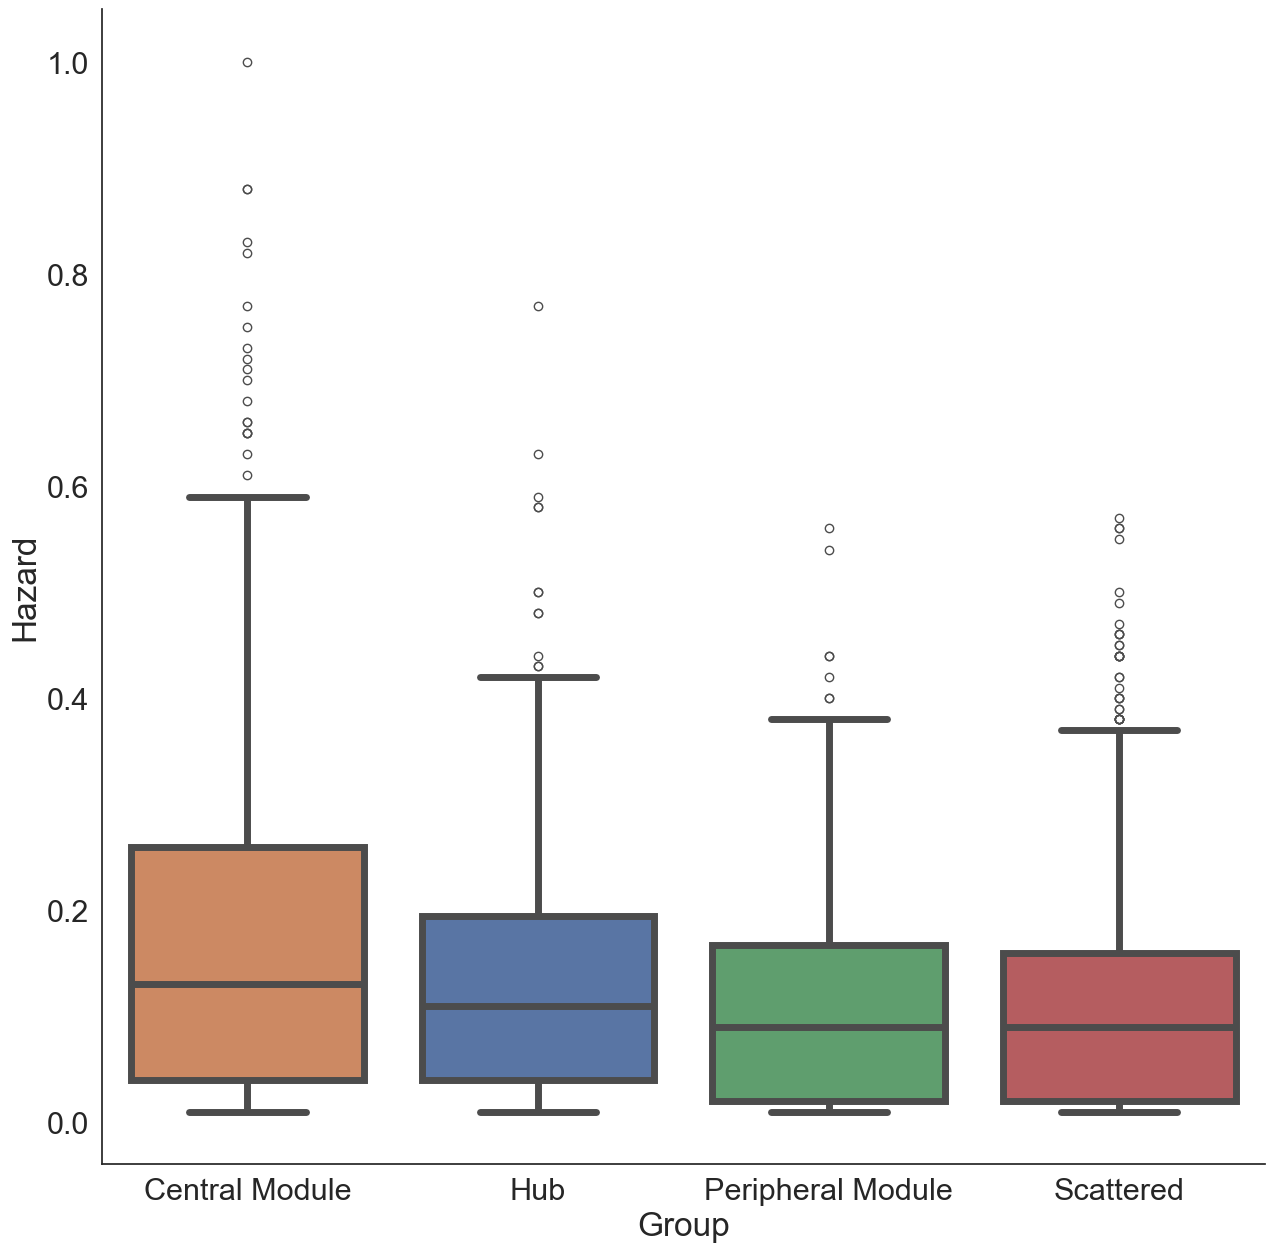

In [42]:
import pandas as pd
column_names = ["Hazard", "Group"]

haz_count_df = pd.DataFrame(columns = column_names)

for val in list(hub_exposures_haz_dict.values()):
    if str(val)!='nan':
        new_row={"Hazard":val,"Group":"Hub"}
        haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)
    
for val in list(central_module_haz_dict.values()):
    if str(val)!='nan':
        new_row={"Hazard":val,"Group":"Central Module"}
        haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)
    
for val in list(peripheric_module_haz_dict.values()):
    if str(val)!='nan':
        new_row={"Hazard":val,"Group":"Peripheral Module"}
        haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)
    
    
for val in list(no_central_no_module_exposures_dict.values()):
    if str(val)!='nan':
        new_row={"Hazard":val,"Group":"Scattered"}
        haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)
        
        from itertools import combinations
pairs = list(combinations(list(set(haz_count_df['Group'])), r=2))


#Let's visualize as boxplot
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

list_palette=list(sns.color_palette())

my_pal = {"Central Module":list_palette[1] , "Hub": list_palette[0], "Peripheral Module":list_palette[2], "Scattered":list_palette[3]}


g=sns.boxplot(data=haz_count_df,x="Group", y="Hazard",order=["Central Module","Hub","Peripheral Module","Scattered"],palette=my_pal,linewidth=5)

ax.grid(False)

#plt.savefig('output/Figures/SF7E_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.show()

In [56]:
#Let's make some statistics
import scipy

hub_haz_list_cleaned = [i for i in list(hub_exposures_haz_dict.values()) if str(i)!='nan']
nocentral_nomodule_haz_list_cleaned = [i for i in list(no_central_no_module_exposures_dict.values()) if str(i)!='nan']
peripheric_module_haz_list_cleaned = [i for i in list(peripheric_module_haz_dict.values()) if str(i)!='nan']
central_module_haz_list_cleaned = [i for i in list(central_module_haz_dict.values()) if str(i)!='nan']



print(scipy.stats.mannwhitneyu(hub_haz_list_cleaned, nocentral_nomodule_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(central_module_haz_list_cleaned, nocentral_nomodule_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(peripheric_module_haz_list_cleaned, nocentral_nomodule_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(central_module_haz_list_cleaned, peripheric_module_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(hub_haz_list_cleaned, central_module_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(hub_haz_list_cleaned, peripheric_module_haz_list_cleaned, use_continuity=True, alternative='two-sided'))


MannwhitneyuResult(statistic=210165.0, pvalue=0.0008166134450235309)
MannwhitneyuResult(statistic=1117489.0, pvalue=1.8014279533075417e-17)
MannwhitneyuResult(statistic=136280.0, pvalue=0.9141663683637664)
MannwhitneyuResult(statistic=255991.0, pvalue=7.108083242674686e-07)
MannwhitneyuResult(statistic=272951.0, pvalue=0.03338477221329437)
MannwhitneyuResult(statistic=48229.5, pvalue=0.009159863897277201)


In [43]:
palette = {"Central Module":"#DF5435" , "Hub": "#EDAB49", "Peripheral Module":"#E88F87", "Scattered":"#F9E5C8"}
haz_count_df["Color"] = haz_count_df["Group"].map(palette)

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    haz_count_df.to_excel(
        writer,
        sheet_name="SF14F",
        index=False
    )

In [44]:
chem_gene_homo_mouse_max_degree={}
for chem, genelist in chem_gene_homo_mouse.items():
    n_genelist = set(genelist) & G_ppi_lcc.nodes()
    if len(n_genelist)>0:
        chem_gene_homo_mouse_max_degree[chem]=max_degree(n_genelist)

In [45]:
#Then, we will make a correlation plot to visualize whether there is a positive correlation between degree and hazard
import scipy

max_deg_list=[]
haz_list=[]
for chem,haz in susdat_toxicity_ctd_full_dict.items():
    if str(haz)!='nan':
        try:
            max_deg_list.append(chem_gene_homo_mouse_max_degree[chem])
            haz_list.append(haz)
        except:
            pass


print(scipy.stats.pearsonr(max_deg_list,haz_list))  # Pearson's r
print(scipy.stats.spearmanr(max_deg_list,haz_list)) # Spearman's rho

PearsonRResult(statistic=0.2419611304269645, pvalue=1.5246903164864566e-46)
SignificanceResult(statistic=0.19672932249872863, pvalue=4.789112517917238e-31)


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_37255/2544835189.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([round(i,2) for i in ax.get_yticks()], size = 36)


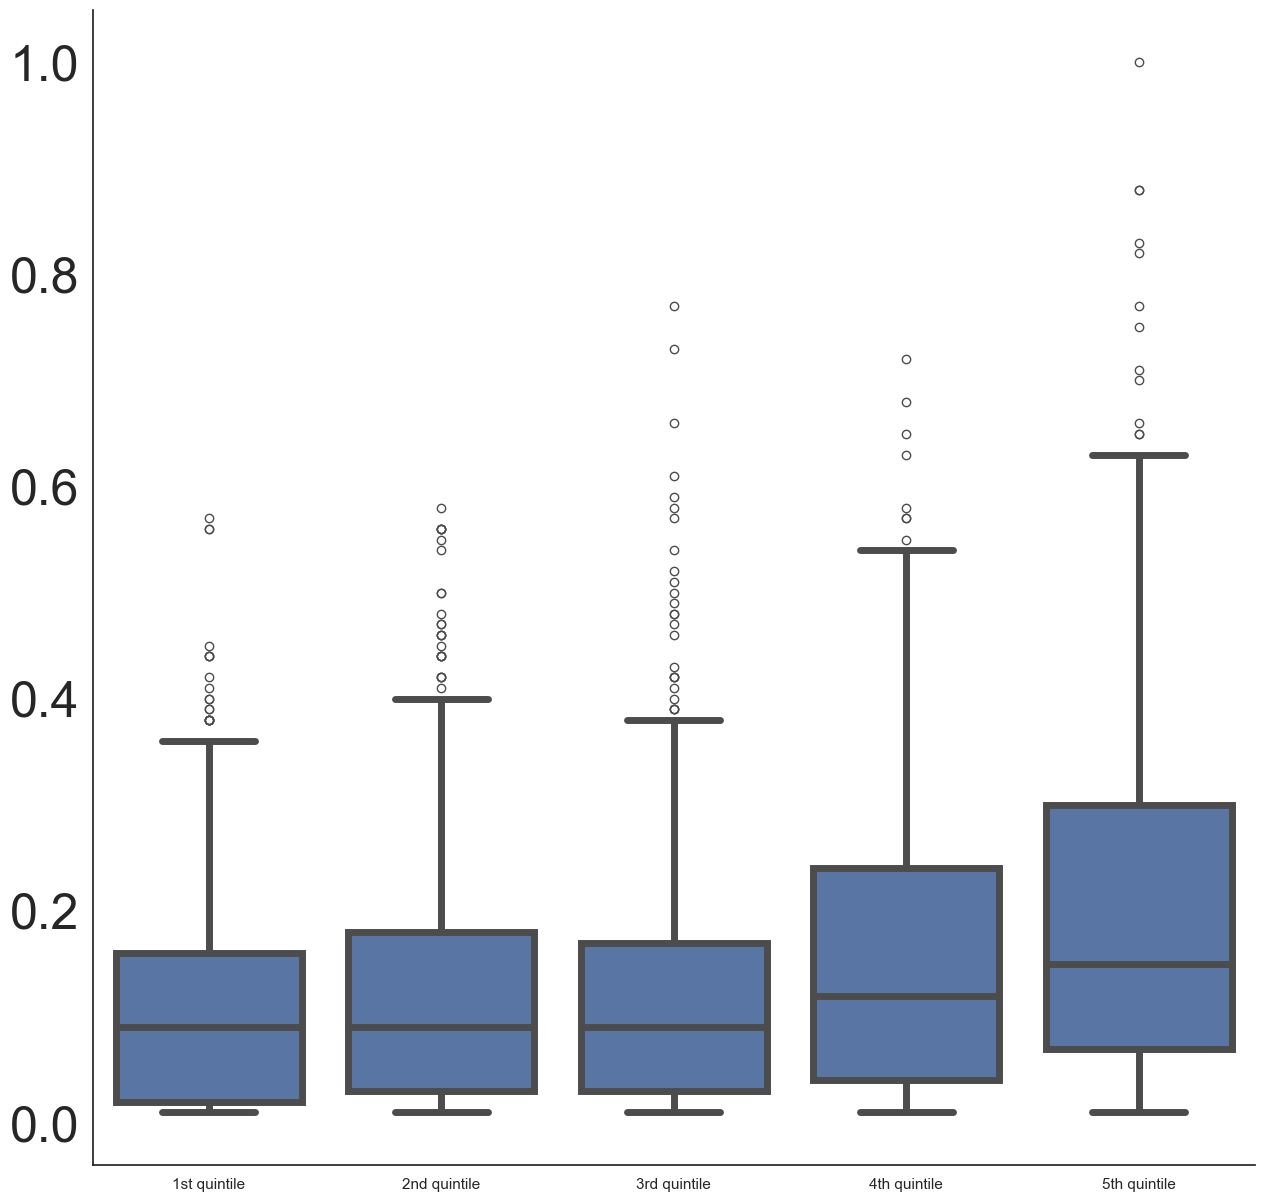

In [46]:
column_names = ["Hazard", "Degree"]

deg_haz_df = pd.DataFrame(columns = column_names)
deg_haz_df['Hazard']=haz_list
deg_haz_df['Degree']=max_deg_list
deg_haz_df_sort_by_degree=deg_haz_df.sort_values("Degree")
cat_list=[]
for i in range(len(deg_haz_df_sort_by_degree)):
    if i<len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("1st quintile")
    elif i>len(deg_haz_df_sort_by_degree)/5 and i<2*len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("2nd quintile")
    elif i>2*len(deg_haz_df_sort_by_degree)/5 and i<3*len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("3rd quintile")
    elif i>3*len(deg_haz_df_sort_by_degree)/5 and i<4*len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("4th quintile")
    else:
        cat_list.append("5th quintile")
        
deg_haz_df_sort_by_degree["Group"]=cat_list

#Let's visualize as boxplot
import seaborn as sns
import matplotlib.pyplot as plt

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
fig, ax = plt.subplots(figsize=(15, 15))

sns.set_style('white')
sns.set(style="white",font_scale = 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
g=sns.boxplot(data=deg_haz_df_sort_by_degree,x="Group", y="Hazard",order=['1st quintile','2nd quintile', '3rd quintile','4th quintile',
 '5th quintile'],linewidth=5)
plt.xlabel('',fontsize=22)
plt.ylabel('', fontsize=22)
#plt.xticks([], fontsize=22)
ax.grid(False)
ax.set_yticklabels([round(i,2) for i in ax.get_yticks()], size = 36)
#ax.set_xticklabels(ax.get_xticks(), size = 36)
#plt.savefig('output/Figures/SF7G_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
#g.set_yscale("log")

plt.show()

In [47]:

# Make a clean copy
df_box = deg_haz_df_sort_by_degree.copy()

# Ensure correct ordering
order = ['1st quintile',
         '2nd quintile',
         '3rd quintile',
         '4th quintile',
         '5th quintile']

df_box["Group"] = pd.Categorical(df_box["Group"],
                                 categories=order,
                                 ordered=True)

# Add numeric group index (useful for reviewers)
df_box["Group_index"] = df_box["Group"].cat.codes + 1

# Keep only relevant columns
df_box_export = df_box[["Group",
                        "Group_index",
                        "Hazard"]]

print("Total observations:", len(df_box_export))
print(df_box_export.groupby("Group").size())

# ----------------------------
# SAVE TO EXCEL
# ----------------------------

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_box_export.to_excel(writer,
                           sheet_name="SF14H",
                           index=False)

print("Boxplot source data saved successfully.")

Total observations: 3404
Group
1st quintile    681
2nd quintile    681
3rd quintile    681
4th quintile    681
5th quintile    680
dtype: int64


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_37255/2155877098.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_box_export.groupby("Group").size())


Boxplot source data saved successfully.
